## 16<sup>th</sup> of April, 2020
## Benjamin Adam Catching
## Coronavirus Simulation
## Andino Lab

In [1]:
# Import python packages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
import pandas as pd
import scipy

The baseline simulation works, where the half of cases in a population are due to asymptomatic transmission. The simulation code takes a while to run for $n_{agents} > 200$. Today the code needs to be finalized to recover the $R_{o}$ value of 2.5. This should be calculated in the time period containing the largest burst of infections. 

The parameters of velocity and density will be the knobs adjusted to recover a growth in symptomatic cases that the $R_{o}$. To automate this process, a function will be created to measure the $R_{o}$ of a given run. Then an array of systems will be iterated over to find parameters that best describe real-life infection rates.

In [2]:
# Start with EDA of yesterday's simulated data
# Read in file
dataname = '../../data/asympt_test_mask.csv'
asympt_df = pd.read_csv(dataname, header=1)
asympt_df.head()

,time,percent sheltering,percent wearing masks,infected,exposed,recovered,infected with mask,susceptible with mask,infected symptomatic,infected asymptomatic
0,0,0.0,0.0,0,1,0,0,0,0,0
1,0,0.0,0.0,0,1,0,0,0,0,0
2,1,0.0,0.0,0,1,0,0,0,0,0
3,2,0.0,0.0,0,1,0,0,0,0,0
4,3,0.0,0.0,0,1,0,0,0,0,0


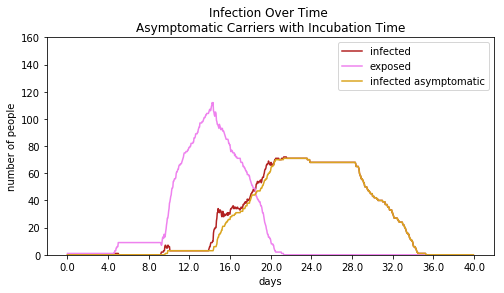

In [8]:
_ = plt.figure(figsize=(8, 4))
_ = plt.plot(asympt_df['time'], asympt_df['infected'], 
             color='firebrick', label='infected')
_ = plt.plot(asympt_df['time'], asympt_df['exposed'], 
         color='violet', label='exposed')
_ = plt.plot(asympt_df['time'], asympt_df['infected asymptomatic'], 
             color='goldenrod', label='infected asymptomatic')
_ = plt.ylabel('number of people')
_ = plt.xlabel('days')
_ = plt.title('Infection Over Time \n'+
              'Asymptomatic Carriers with Incubation Time')
_ = plt.legend()
_ = plt.xticks(np.linspace(0, len(asympt_df[['time']]), 11), np.linspace(0, 40, 11))
_ = plt.ylim([0, 160])
plt.show()

The $R_{o}$ is determined (for a SEIR model) by the number of agents infected (or would be infected) during the infectious course of an infection. Including the number of agents who would be infected is due to a closed system having a finite number of agents that may already be infected. In the code there will be included a place to record the number of individuals that would be infected, so that at the end of the simulation each agent will have a number of other agents they had the ability to infect.  

First bring in the code again and make modifications.

0.0% done
0.0% done
10.0% done
20.0% done
30.0% done
40.0% done
50.0% done
60.0% done
70.0% done
80.0% done
90.0% done
0.0% done


Traceback (most recent call last):
  File "/Users/adam/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 215, in process
    func(*args, **kwargs)
  File "/Users/adam/anaconda3/lib/python3.7/site-packages/matplotlib/animation.py", line 999, in _start
    self._init_draw()
  File "/Users/adam/anaconda3/lib/python3.7/site-packages/matplotlib/animation.py", line 1740, in _init_draw
    self._draw_frame(next(self.new_frame_seq()))
  File "/Users/adam/anaconda3/lib/python3.7/site-packages/matplotlib/animation.py", line 1762, in _draw_frame
    self._drawn_artists = self._func(framedata, *self._args)
  File "<ipython-input-37-3b9be9061757>", line 368, in update
    f.write(temp_write)
ValueError: I/O operation on closed file.


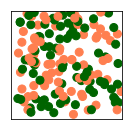

In [37]:
# Import python packages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


# Name the datafile
run_name = 'asympt_test_mask'
dataname = '../../data/' + run_name + '.csv'
f = open(dataname, 'w')
# Write header of the file
f.write('# Data from simulation of 200 agents with various levels\
 of sheltering or mask usage\n')
f.write('time,percent sheltering,percent wearing masks,infected,\
exposed,recovered,infected with mask,susceptible with mask\n')

        
"""Values of the simulation"""
# Fixing random state for reproducibility
np.random.seed(42)

# Figure ratio
fig_rat = .2
# Set boundaries
xboundaries = [0, 50 * fig_rat]
yboundaries = [0, 50 * fig_rat]
xmax, ymax = xboundaries[1]+.5 , yboundaries[1]+.5

# Number of steps
N_steps = 720
# Number of agents
n_agents = int(4000 * round(fig_rat ** 2, 2))
# Set delta t
dt = 1
# Set velocity
velo = .2
# Set percent of sheltering in place
per_shelt = 0
# Set percent of masked agents
per_mask = 0

# Define the array of agents with given properties
agents = np.zeros(n_agents, dtype=[('position', float, 2),
                                   ('velocity', float, 2),
                                   ('color', str, 20),
                                   ('state', str, 20),
                                   ('time', int, 1),
                                   ('symptomatic', int, 1),
                                   ('num infected', int, 1),
                                   ('mask', bool, 1),
                                   ('touch', int, 1)])



"""Calculate initial values of agents"""
# Define the initial random positions within the figure
agents['position'] = np.random.uniform(0, xmax, (n_agents, 2))
# Define the initial velocity angles
init_angles = np.random.uniform(0, 2 * np.pi, n_agents)
# Get initial x and y velocities from angles
velocities = np.array([[np.sin(x), np.cos(x)] for x in init_angles]) 
velocities *= velo
# Get percentage of agents 'sheltering'
num_shelt = int(per_shelt * n_agents)
# Make sheltering agents static (if any)
velocities[:num_shelt] = np.zeros((num_shelt, 2))
# Number of hours for asymptomatic incubation
asympt_incubate = 24 * 5.1
# Number of hours for symptomatic incubation
sympt_incubate = 24 * 4.6
# Number of hours for asymptomatic infection
asympt_infect = 21*24
# Number of hours for symptomatic infection
sympt_infect = 12
# Define values for infection gamma pdf
g_shape, g_scale = 0.25, 4
# Probability reduction for asymptomatic carrier
asym_prob = .66


"""Assign values to agents"""
# Assign velocities
agents['velocity'] = velocities
# Assign color (Navy is the default susceptible agent)
agents['color'] = np.array(['Navy'] * n_agents)
# Set agents to be symptomatic
agents['state'] = np.array(['Susceptible'] * n_agents)
agents['time'] = np.array([0] * n_agents)
n_mask = [True] * per_mask + [False] * (10-per_mask)
agents['mask'] = np.random.choice(n_mask, n_agents, replace=True)
agents['color'][agents['mask'] == True] = 'Dodgerblue'
agents['symptomatic'] = np.zeros(n_agents)
agents['num infected'] = np.zeros(n_agents)

# Make the one agent infected
agents['color'][0] = 'Violet'
agents['state'][0] = 'Exposed'
agents['time'][0] = 1
agents['mask'][0] = False
agents['symptomatic'][0] = 1


"""Define the values of the display"""
# Define the figure
fig = plt.figure(figsize=(10 * fig_rat, 10 * fig_rat))
ax = plt.axes(xlim=(-.5, xmax), ylim=(-.5, ymax))
plt.xticks([])
plt.yticks([])

# Initialize the plot
scatter = ax.scatter(agents['position'][:, 0], 
                     agents['position'][:, 1],
                     color=agents['color'],
                     s=64)

def update(i):
    """
    Take the information from the data stored in the agents array
    to calculate if an infected agent recovers, if two agents 
    interact, and if the agent bounces off a boundary
    """
    if i % int(N_steps / 10) == 0:
        print(str(i / int(N_steps / 10) * 10) + '% done')

    # Iterate over all agents 
    for j in range(n_agents):
        if agents['time'][j] != 0:
            # Calculate if agent is exposed or infected
            agent_j_infected = agents['state'][j] == 'Infected'
            agent_j_exposed = agents['state'][j] == 'Exposed'
            # Store time agent has been in this state
            agent_j_time = agents['time'][j]
            # Calculate if the agent is symptomatic or not
            agent_j_sympt = agents['symptomatic'][j]
            if agent_j_infected and agent_j_sympt:
                if agents['time'][j] >= sympt_infect:
                    agents['state'][j] = 'Recovered'
                    agents['color'][j] = 'Darkgreen'
                    agents['time'][j] = 1
                else:
                    agents['time'][j] += 1
            elif agent_j_infected and not agent_j_sympt:
                if agents['time'][j] >= asympt_infect:
                    agents['state'][j] = 'Recovered'
                    agents['color'][j] = 'Darkgreen'
                    agents['time'][j] = 1
                else:
                    agents['time'][j] += 1
            elif agent_j_exposed and agent_j_sympt:
                if agents['time'][j] >= sympt_incubate:
                    agents['state'][j] = 'Infected'
                    agents['color'][j] = 'Firebrick'
                    agents['time'][j] = 1
                else:
                    agents['time'][j] += 1
            elif agent_j_exposed and not agent_j_sympt:
                if agents['time'][j] >= asympt_incubate:
                    agents['state'][j] = 'Infected'
                    agents['color'][j] = 'Coral'
                    agents['time'][j] = 1
                else:
                    agents['time'][j] += 1
                
        # New displacements (prior velocity times change in time)
        deltax_temp = dt * agents['velocity'][j, 0]
        deltay_temp = dt * agents['velocity'][j, 1]
        # New positions
        x = agents['position'][j, 0] + deltax_temp
        y = agents['position'][j, 1] + deltay_temp
        # Compute new velocity
        vx_temp = deltax_temp / dt
        vy_temp = deltay_temp / dt

        # Add interaction
        for k in range(n_agents):
            # Go through all other agents that could be interacted with
            if k != j:
                # Compute components of distance
                dx = agents['position'][j, 0] - agents['position'][k, 0]
                dy = agents['position'][j, 1] - agents['position'][k, 1]
                # Compute distance between agents
                dist_temp = np.sqrt(dx ** 2 + dy ** 2)
                # If distance of interaction is closer than both radii, collide
                if dist_temp <= 1:
                    agents['touch'][j] += 1
                    # Calculate if agents are infected
                    agent_j_infected = agents['state'][j] == 'Infected'
                    agent_k_infected = agents['state'][k] == 'Infected'
                    # Calculate if agents have recovered
                    agent_k_recover = agents['state'][k] == 'Recovered'
                    # Calculate if agents are susceptible
                    agent_j_suscept = agents['state'][j] == 'Susceptible'
                    agent_k_suscept = agents['state'][k] == 'Susceptible'
                    # Calculate if agents are symptomatic
                    agent_j_sympt = agents['symptomatic'][j] == 1
                    # If agent j is infected and agent k is susceptible
                    if agent_j_infected:
                        if agent_j_sympt and agent_k_suscept:
                            # Calculate probability of infection
                            temp_gam = np.random.gamma(g_shape, g_scale)
                            if temp_gam >= 1:
                                # Are the agents wearing masks
                                agent_j_mask = agents['mask'][j] == True
                                agent_k_mask = agents['mask'][k] == True
                                # If the infected is not wearing a mask
                                if not agent_j_mask and agent_k_mask:
                                    if np.random.random() >= .85:
                                        agents['state'][k] = 'Exposed'
                                        if np.random.random() >= .5:
                                            agents['symptomatic'][k] = 1
                                            agents['color'][k] = 'Violet'
                                        else:
                                            agents['symptomatic'][k] = 0
                                            agents['color'][k] = 'Indigo'
                                        agents['time'][k] = 1
                                        agents['num infected'][j] += 1
                                # If the susceptible is wearing a mask
                                elif agent_j_mask and not agent_k_mask:
                                    if np.random.random() >= .95:
                                        agents['state'][k] = 'Exposed'
                                        if np.random.random() >= .5:
                                            agents['symptomatic'][k] = 1
                                            agents['color'][k] = 'Violet'
                                        else:
                                            agents['symptomatic'][k] = 0
                                            agents['color'][k] = 'Indigo'
                                        agents['time'][k] = 1
                                        agents['num infected'][j] += 1
                                # If neither are wearing masks
                                elif not agent_j_mask and not agent_k_mask:
                                    agents['state'][k] = 'Exposed'
                                    if np.random.random() >= .5:
                                        agents['symptomatic'][k] = 1
                                        agents['color'][k] = 'Violet'
                                    else:
                                        agents['symptomatic'][k] = 0
                                        agents['color'][k] = 'Indigo'
                                    agents['time'][k] = 1
                                    agents['num infected'][j] += 1
                        elif not agent_j_sympt and agent_k_suscept:
                            # Get the time that agent j has been infectious
                            agent_j_time = agents['time'][j]
                            # Normalize time to infectious period
                            agent_j_norm_time = agent_j_time / asympt_infect
                            # Define the probability of asymptomatic infect
                            temp_gam = np.random.gamma(g_shape, g_scale)
                            asympt_gam = temp_gam * asym_prob * agent_j_norm_time
                            if asympt_gam >=1:
                                # Are the agents wearing masks
                                agent_j_mask = agents['mask'][j] == True
                                agent_k_mask = agents['mask'][k] == True
                                
                                # If the infected is not wearing a mask
                                if not agent_j_mask and agent_k_mask:
                                    if np.random.random() >= .85:
                                        agents['state'][k] = 'Exposed'
                                        if np.random.random() >= .5:
                                            agents['symptomatic'][k] = 1
                                            agents['color'][k] = 'Violet'
                                            agents['num infected'][j] += 1
                                        else:
                                            agents['symptomatic'][k] = 0
                                            agents['color'][k] = 'Indigo'
                                        agents['time'][k] = 1
                                        
                                # If the susceptible is wearing a mask
                                elif agent_j_mask and not agent_k_mask:
                                    if np.random.random() >= .95:
                                        agents['state'][k] = 'Exposed'
                                        if np.random.random() >= .5:
                                            agents['symptomatic'][k] = 1
                                            agents['color'][k] = 'Violet'
                                            agents['num infected'][j] += 1
                                        else:
                                            agents['symptomatic'][k] = 0
                                            agents['color'][k] = 'Indigo'
                                        agents['time'][k] = 1
                                        
                                # If neither are wearing masks
                                elif not agent_j_mask and not agent_k_mask:
                                    agents['state'][k] = 'Exposed'
                                    if np.random.random() >= .5:
                                        agents['symptomatic'][k] = 1
                                        agents['color'][k] = 'Violet'
                                        agents['num infected'][j] += 1
                                    else:
                                        agents['symptomatic'][k] = 0
                                        agents['color'][k] = 'Indigo'
                                    agents['time'][k] = 1
                                    
                        # Calculate if infection would have occured
                        elif agent_j_sympt:
                            if agent_k_infected or agent_k_recover:
                                temp_gam = np.random.gamma(g_shape, g_scale)
                                if temp_gam >= 1:
                                    # Are the agents wearing masks
                                    agent_j_mask = agents['mask'][j] == True
                                    agent_k_mask = agents['mask'][k] == True
                                    # If the infected is not wearing a mask
                                    if not agent_j_mask and agent_k_mask:
                                        if np.random.random() >= .85/2:
                                            agents['num infected'][j] += 1
                                    # If the susceptible is wearing a mask
                                    elif agent_j_mask and not agent_k_mask:
                                        if np.random.random() >= .95/2:
                                            agents['num infected'][j] += 1
                                    # If neither are wearing masks
                                    elif not agent_j_mask and not agent_k_mask:
                                        if np.random.random() >= .5:
                                            agents['num infected'][j] += 1
                        elif not agent_j_sympt:
                            if agent_k_infected or agent_k_recover:
                                # Define the probability of asymptomatic infect
                                temp_gam = np.random.gamma(g_shape, g_scale)
                                asympt_gam = temp_gam * asym_prob
                                if asympt_gam >=1:
                                    # Are the agents wearing masks
                                    agent_j_mask = agents['mask'][j] == True
                                    agent_k_mask = agents['mask'][k] == True
                                    # If the infected is not wearing a mask
                                    if not agent_j_mask and agent_k_mask:
                                        if np.random.random() >= .85/2:
                                            agents['num infected'][j] += 1
                                    # If the susceptible is wearing a mask
                                    elif agent_j_mask and not agent_k_mask:
                                        if np.random.random() >= .95/2:
                                            agents['num infected'][j] += 1
                                    # If neither are wearing masks
                                    elif not agent_j_mask and not agent_k_mask:
                                        if np.random.random() >= .5:
                                            agents['num infected'][j] += 1

        # Bounce agents off wall if projected position is beyond boundary conditions
        if x >= xmax:
            x = 2 * xmax - deltax_temp - agents['position'][j, 0]
            vx_temp *= -1
        elif x <= 0:
            x = - deltax_temp - agents['position'][j, 0]
            vx_temp *= -1
        elif y >= ymax:
            y = 2 * ymax - deltay_temp - agents['position'][j, 1]
            vy_temp *= -1
        elif y <= 0:
            y = - deltay_temp - agents['position'][j, 1]
            vy_temp *= -1

        # 
        agents['position'][j] = np.array([x, y])
        agents['velocity'][j, 0] = vx_temp
        agents['velocity'][j, 1] = vy_temp

        # Update the scatter collection, with the new colors, sizes and positions.
        scatter.set_color(agents['color'])
        scatter.set_offsets(agents['position'])
    # Get values of the current time step
    temp_infected = sum(agents['state']=='Infected')
    temp_recovered = sum(agents['state']=='Recovered')
    temp_infect_mask = sum(agents[agents['mask']==True]['state'] =='Infected')
    temp_suscept_mask = sum(agents[agents['mask']==True]['state']=='Susceptible')
    temp_exposed = sum(agents['state']=='Exposed')
    temp_num_infected = agents['num infected']
    temp_write = str(i) + ',' + str(round(per_shelt * .1, 1)) + ',' + \
                 str(round(per_mask * .1, 1)) + ',' + str(temp_infected)+ ',' \
                 + str(temp_exposed) + ',' + str(temp_recovered) + ',' + \
                 str(temp_infect_mask) + ',' + str(temp_suscept_mask) \
                 + '\n'
    # Save current data to a file
    f.write(temp_write)

# Animate the simulation by iterating
animation = FuncAnimation(fig, update, frames=N_steps, interval=20)
temp_name = '../../data/' + run_name + '.gif'
animation.save(temp_name, writer='imagemagick')
f.close()

Mean: 43.88125
Standard deviation: 43.834685449282055


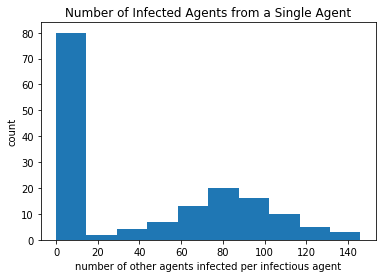

In [41]:
num_mean = agents["num infected"].mean()
print(f'Mean: {num_mean}')
num_std = agents["num infected"].std()
print(f'Standard deviation: {num_std}')
_ = plt.hist(agents['num infected'])
_ = plt.xlabel('number of other agents infected per infectious agent')
_ = plt.ylabel('count')
_ = plt.title('Number of Infected Agents from a Single Agent')
plt.show()

In [42]:
# Start with EDA of yesterday's simulated data
# Read in file
dataname = '../../data/asympt_test_mask.csv'
asympt_df = pd.read_csv(dataname, header=1)
asympt_df.head()

,time,percent sheltering,percent wearing masks,infected,exposed,recovered,infected with mask,susceptible with mask
0,0,0.0,0.0,0,1,0,0,0
1,0,0.0,0.0,0,1,0,0,0
2,1,0.0,0.0,0,1,0,0,0
3,2,0.0,0.0,0,1,0,0,0
4,3,0.0,0.0,0,1,0,0,0


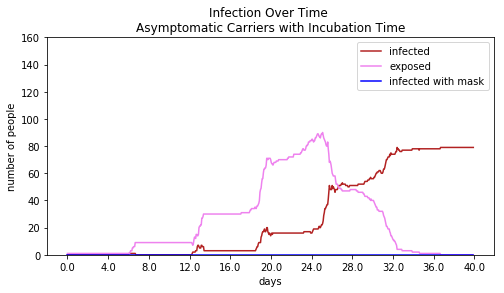

In [43]:
_ = plt.figure(figsize=(8, 4))
_ = plt.plot(asympt_df['time'], asympt_df['infected'], 
             color='firebrick', label='infected')
_ = plt.plot(asympt_df['time'], asympt_df['exposed'], 
         color='violet', label='exposed')
_ = plt.plot(asympt_df['time'], asympt_df['infected with mask'], 
             color='blue', label='infected with mask')
_ = plt.ylabel('number of people')
_ = plt.xlabel('days')
_ = plt.title('Infection Over Time \n'+
              'Asymptomatic Carriers with Incubation Time')
_ = plt.legend()
_ = plt.xticks(np.linspace(0, len(asympt_df[['time']]), 11), np.linspace(0, 40, 11))
_ = plt.ylim([0, 160])
plt.show()

0.0% done
0.0% done
10.0% done
20.0% done
30.0% done
40.0% done
50.0% done
60.0% done
70.0% done
80.0% done
90.0% done
0.0% done


Traceback (most recent call last):
  File "/Users/adam/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 215, in process
    func(*args, **kwargs)
  File "/Users/adam/anaconda3/lib/python3.7/site-packages/matplotlib/animation.py", line 999, in _start
    self._init_draw()
  File "/Users/adam/anaconda3/lib/python3.7/site-packages/matplotlib/animation.py", line 1740, in _init_draw
    self._draw_frame(next(self.new_frame_seq()))
  File "/Users/adam/anaconda3/lib/python3.7/site-packages/matplotlib/animation.py", line 1762, in _draw_frame
    self._drawn_artists = self._func(framedata, *self._args)
  File "<ipython-input-62-f9f2db046b02>", line 378, in update
    f.write(temp_write)
ValueError: I/O operation on closed file.


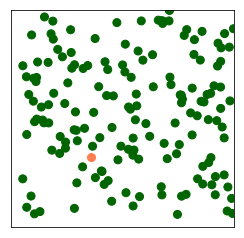

In [62]:
# Name the datafile
run_name = 'asympt_test_03'
dataname = '../../data/' + run_name + '.csv'
f = open(dataname, 'w')
# Write header of the file
f.write('# Data from simulation of 200 agents with various levels\
 of sheltering or mask usage\n')
f.write('time,percent sheltering,percent wearing masks,infected,\
exposed,recovered,infected with mask,susceptible with mask,\
infected symptomatic,infected asymptomatic\n')

        
"""Values of the simulation"""
# Fixing random state for reproducibility
np.random.seed(42)

# Figure ratio
fig_rat = .2
# Set boundaries
xboundaries = [0, 50 * fig_rat]
yboundaries = [0, 50 * fig_rat]
xmax, ymax = xboundaries[1]+.5 , yboundaries[1]+.5

# Number of steps
N_steps = 960
# Number of agents
n_agents = int(4000 * round(fig_rat ** 2, 2))
# Set delta t
dt = 1
# Set velocity
velo = .2
# Set percent of sheltering in place
per_shelt = 0
# Set percent of masked agents
per_mask = 0

# Define the array of agents with given properties
agents = np.zeros(n_agents, dtype=[('position', float, 2),
                                   ('velocity', float, 2),
                                   ('color', str, 20),
                                   ('state', str, 20),
                                   ('time', int, 1),
                                   ('symptomatic', int, 1),
                                   ('num infected', int, 1),
                                   ('mask', bool, 1),
                                   ('touch', int, 1)])



"""Calculate initial values of agents"""
# Define the initial random positions within the figure
agents['position'] = np.random.uniform(0, xmax, (n_agents, 2))
# Define the initial velocity angles
init_angles = np.random.uniform(0, 2 * np.pi, n_agents)
# Get initial x and y velocities from angles
velocities = np.array([[np.sin(x), np.cos(x)] for x in init_angles]) 
velocities *= velo
# Get percentage of agents 'sheltering'
num_shelt = int(per_shelt * n_agents)
# Make sheltering agents static (if any)
velocities[:num_shelt] = np.zeros((num_shelt, 2))
# Number of hours for asymptomatic incubation
asympt_incubate = 24 * 5.1
# Number of hours for symptomatic incubation
sympt_incubate = 24 * 4.6
# Number of hours for asymptomatic infection
asympt_infect = 14*24
# Number of hours for symptomatic infection
sympt_infect = 12
# Define values for infection gamma pdf
g_shape, g_scale = 0.25, 4
# Probability reduction for asymptomatic carrier
asym_prob = .66


"""Assign values to agents"""
# Assign velocities
agents['velocity'] = velocities
# Assign color (Navy is the default susceptible agent)
agents['color'] = np.array(['Navy'] * n_agents)
# Set agents to be symptomatic
agents['state'] = np.array(['Susceptible'] * n_agents)
agents['time'] = np.array([0] * n_agents)
n_mask = [True] * per_mask + [False] * (10-per_mask)
agents['mask'] = np.random.choice(n_mask, n_agents, replace=True)
agents['color'][agents['mask'] == True] = 'Dodgerblue'
agents['symptomatic'] = np.zeros(n_agents)
agents['num infected'] = np.zeros(n_agents)

# Make the one agent infected
agents['color'][0] = 'Violet'
agents['state'][0] = 'Exposed'
agents['time'][0] = 1
agents['mask'][0] = False
agents['symptomatic'][0] = 1


"""Define the values of the display"""
# Define the figure
fig = plt.figure(figsize=(20 * fig_rat, 20 * fig_rat))
ax = plt.axes(xlim=(-.5, xmax), ylim=(-.5, ymax))
plt.xticks([])
plt.yticks([])

# Initialize the plot
scatter = ax.scatter(agents['position'][:, 0], 
                     agents['position'][:, 1],
                     color=agents['color'],
                     s=64)

def update(i):
    """
    Take the information from the data stored in the agents array
    to calculate if an infected agent recovers, if two agents 
    interact, and if the agent bounces off a boundary
    """
    
    if i % int(N_steps / 10) == 0:
        print(str(i / int(N_steps / 10) * 10) + '% done')

    # Iterate over all agents 
    for j in range(n_agents):
        if agents['time'][j] != 0:
            # Calculate if agent is exposed or infected
            agent_j_infected = agents['state'][j] == 'Infected'
            agent_j_exposed = agents['state'][j] == 'Exposed'
            # Store time agent has been in this state
            agent_j_time = agents['time'][j]
            # Calculate if the agent is symptomatic or not
            agent_j_sympt = agents['symptomatic'][j]
            if agent_j_infected and agent_j_sympt:
                if agents['time'][j] >= sympt_infect:
                    agents['state'][j] = 'Recovered'
                    agents['color'][j] = 'Darkgreen'
                    agents['time'][j] = 1
                else:
                    agents['time'][j] += 1
            elif agent_j_infected and not agent_j_sympt:
                if agents['time'][j] >= asympt_infect:
                    agents['state'][j] = 'Recovered'
                    agents['color'][j] = 'Darkgreen'
                    agents['time'][j] = 1
                else:
                    agents['time'][j] += 1
            elif agent_j_exposed and agent_j_sympt:
                if agents['time'][j] >= sympt_incubate:
                    agents['state'][j] = 'Infected'
                    agents['color'][j] = 'Firebrick'
                    agents['time'][j] = 1
                else:
                    agents['time'][j] += 1
            elif agent_j_exposed and not agent_j_sympt:
                if agents['time'][j] >= asympt_incubate:
                    agents['state'][j] = 'Infected'
                    agents['color'][j] = 'Coral'
                    agents['time'][j] = 1
                else:
                    agents['time'][j] += 1
                
        # New displacements (prior velocity times change in time)
        deltax_temp = dt * agents['velocity'][j, 0]
        deltay_temp = dt * agents['velocity'][j, 1]
        # New positions
        x = agents['position'][j, 0] + deltax_temp
        y = agents['position'][j, 1] + deltay_temp
        # Compute new velocity
        vx_temp = deltax_temp / dt
        vy_temp = deltay_temp / dt

        # Add interaction
        for k in range(n_agents):
            # Go through all other agents that could be interacted with
            if k != j:
                # Compute components of distance
                dx = agents['position'][j, 0] - agents['position'][k, 0]
                dy = agents['position'][j, 1] - agents['position'][k, 1]
                # Compute distance between agents
                dist_temp = np.sqrt(dx ** 2 + dy ** 2)
                # If distance of interaction is closer than both radii, collide
                if dist_temp <= 1:
                    agents['touch'][j] += 1
                    # Calculate if agents are infected
                    agent_j_infected = agents['state'][j] == 'Infected'
                    agent_k_infected = agents['state'][k] == 'Infected'
                    # Calculate if agents have recovered
                    agent_k_recover = agents['state'][k] == 'Recovered'
                    # Calculate if agents are susceptible
                    agent_j_suscept = agents['state'][j] == 'Susceptible'
                    agent_k_suscept = agents['state'][k] == 'Susceptible'
                    # Calculate if agents are symptomatic
                    agent_j_sympt = agents['symptomatic'][j] == 1
                    # If agent j is infected and agent k is susceptible
                    if agent_j_infected:
                        if agent_j_sympt and agent_k_suscept:
                            # Calculate probability of infection
                            temp_gam = np.random.gamma(g_shape, g_scale)
                            if temp_gam >= 1:
                                # Are the agents wearing masks
                                agent_j_mask = agents['mask'][j] == True
                                agent_k_mask = agents['mask'][k] == True
                                # If the infected is not wearing a mask
                                if not agent_j_mask and agent_k_mask:
                                    if np.random.random() >= .85:
                                        agents['state'][k] = 'Exposed'
                                        if np.random.random() >= .5:
                                            agents['symptomatic'][k] = 1
                                            agents['color'][k] = 'Violet'
                                            agents['num infected'][j] += 1
                                        else:
                                            agents['symptomatic'][k] = 0
                                            agents['color'][k] = 'Indigo'
                                        agents['time'][k] = 1
                                        
                                # If the susceptible is wearing a mask
                                elif agent_j_mask and not agent_k_mask:
                                    if np.random.random() >= .95:
                                        agents['state'][k] = 'Exposed'
                                        if np.random.random() >= .5:
                                            agents['symptomatic'][k] = 1
                                            agents['color'][k] = 'Violet'
                                            agents['num infected'][j] += 1
                                        else:
                                            agents['symptomatic'][k] = 0
                                            agents['color'][k] = 'Indigo'
                                        agents['time'][k] = 1
                                        
                                # If neither are wearing masks
                                elif not agent_j_mask and not agent_k_mask:
                                    agents['state'][k] = 'Exposed'
                                    if np.random.random() >= .5:
                                        agents['symptomatic'][k] = 1
                                        agents['color'][k] = 'Violet'
                                        agents['num infected'][j] += 1
                                    else:
                                        agents['symptomatic'][k] = 0
                                        agents['color'][k] = 'Indigo'
                                    agents['time'][k] = 1         
                        elif not agent_j_sympt and agent_k_suscept:
                            # Get the time that agent j has been infectious
                            agent_j_time = agents['time'][j]
                            # Normalize time to infectious period
                            agent_j_norm_time = agent_j_time / asympt_infect
                            # Define the probability of asymptomatic infect
                            temp_gam = np.random.gamma(g_shape, g_scale)
                            asympt_gam = temp_gam * asym_prob * agent_j_norm_time
                            if asympt_gam >=1:
                                # Are the agents wearing masks
                                agent_j_mask = agents['mask'][j] == True
                                agent_k_mask = agents['mask'][k] == True

                                # If the infected is not wearing a mask
                                if not agent_j_mask and agent_k_mask:
                                    if np.random.random() >= .85:
                                        agents['state'][k] = 'Exposed'
                                        if np.random.random() >= .5:
                                            agents['symptomatic'][k] = 1
                                            agents['color'][k] = 'Violet'
                                            agents['num infected'][j] += 1
                                        else:
                                            agents['symptomatic'][k] = 0
                                            agents['color'][k] = 'Indigo'
                                        agents['time'][k] = 1
                                        
                                # If the susceptible is wearing a mask
                                elif agent_j_mask and not agent_k_mask:
                                    if np.random.random() >= .95:
                                        agents['state'][k] = 'Exposed'
                                        if np.random.random() >= .5:
                                            agents['symptomatic'][k] = 1
                                            agents['color'][k] = 'Violet'
                                            agents['num infected'][j] += 1
                                        else:
                                            agents['symptomatic'][k] = 0
                                            agents['color'][k] = 'Indigo'
                                        agents['time'][k] = 1
                                        
                                # If neither are wearing masks
                                elif not agent_j_mask and not agent_k_mask:
                                    agents['state'][k] = 'Exposed'
                                    if np.random.random() >= .5:
                                        agents['symptomatic'][k] = 1
                                        agents['color'][k] = 'Violet'
                                        agents['num infected'][j] += 1
                                    else:
                                        agents['symptomatic'][k] = 0
                                        agents['color'][k] = 'Indigo'
                                    agents['time'][k] = 1
                        # Calculate if infection would have occured
                        elif agent_j_sympt:
                            if agent_k_infected or agent_k_recover:
                                # Get the time that agent j has been infectious
                                agent_j_time = agents['time'][j]
                                # Normalize time to infectious period
                                agent_j_norm_time = agent_j_time / asympt_infect
                                # Define the probability of asymptomatic infect
                                temp_gam = np.random.gamma(g_shape, g_scale)
                                asympt_gam = temp_gam * asym_prob * agent_j_norm_time
                                if temp_gam >= 1:
                                    # Are the agents wearing masks
                                    agent_j_mask = agents['mask'][j] == True
                                    agent_k_mask = agents['mask'][k] == True
                                    # If the infected is not wearing a mask
                                    if not agent_j_mask and agent_k_mask:
                                        if np.random.random() >= .85/2:
                                            agents['num infected'][j] += 1
                                    # If the susceptible is wearing a mask
                                    elif agent_j_mask and not agent_k_mask:
                                        if np.random.random() >= .95/2:
                                            agents['num infected'][j] += 1
                                    # If neither are wearing masks
                                    elif not agent_j_mask and not agent_k_mask:
                                        if np.random.random() >= .5:
                                            agents['num infected'][j] += 1
                        elif not agent_j_sympt:
                            if agent_k_infected or agent_k_recover:
                                # Get the time that agent j has been infectious
                                agent_j_time = agents['time'][j]
                                # Normalize time to infectious period
                                agent_j_norm_time = agent_j_time / asympt_infect
                                # Define the probability of asymptomatic infect
                                temp_gam = np.random.gamma(g_shape, g_scale)
                                asympt_gam = temp_gam * asym_prob * agent_j_norm_time
                                if asympt_gam >=1:
                                    # Are the agents wearing masks
                                    agent_j_mask = agents['mask'][j] == True
                                    agent_k_mask = agents['mask'][k] == True
                                    # If the infected is not wearing a mask
                                    if not agent_j_mask and agent_k_mask:
                                        if np.random.random() >= .85/2:
                                            agents['num infected'][j] += 1
                                    # If the susceptible is wearing a mask
                                    elif agent_j_mask and not agent_k_mask:
                                        if np.random.random() >= .95/2:
                                            agents['num infected'][j] += 1
                                    # If neither are wearing masks
                                    elif not agent_j_mask and not agent_k_mask:
                                        if np.random.random() >= .5:
                                            agents['num infected'][j] += 1
                                    
        
        # Bounce agents off wall if projected position is beyond boundary conditions
        if x >= xmax:
            x = 2 * xmax - deltax_temp - agents['position'][j, 0]
            vx_temp *= -1
        elif x <= 0:
            x = - deltax_temp - agents['position'][j, 0]
            vx_temp *= -1
        elif y >= ymax:
            y = 2 * ymax - deltay_temp - agents['position'][j, 1]
            vy_temp *= -1
        elif y <= 0:
            y = - deltay_temp - agents['position'][j, 1]
            vy_temp *= -1

        # 
        agents['position'][j] = np.array([x, y])
        agents['velocity'][j, 0] = vx_temp
        agents['velocity'][j, 1] = vy_temp

        # Update the scatter collection, with the new colors, sizes and positions.
        scatter.set_color(agents['color'])
        scatter.set_offsets(agents['position'])

    # Get values of the current time step
    temp_infected = sum(agents['state']=='Infected')
    temp_recovered = sum(agents['state']=='Recovered')
    temp_infect_mask = sum(agents[agents['mask']==True]['state'] == 'Infected')
    temp_suscept_mask = sum(agents[agents['mask']==True]['state'] == 'Susceptible')
    temp_exposed = sum(agents['state']=='Exposed')
    temp_infect_sympt = sum(agents[agents['symptomatic']==1]['state'] == 'Infected')
    temp_infect_asympt = sum(agents[agents['symptomatic']==0]['state'] == 'Infected')
    temp_write = str(i) + ',' + str(round(per_shelt * .1, 1)) + ',' + \
                 str(round(per_mask * .1, 1)) + ',' + str(temp_infected)+ ',' \
                 + str(temp_exposed) + ',' + str(temp_recovered) + ',' + \
                 str(temp_infect_mask) + ',' + str(temp_suscept_mask) + ',' + \
                 str(temp_infect_sympt) + ',' + str(temp_infect_asympt) + '\n'
    # Save current data to a file
    f.write(temp_write)

# Animate the simulation by iterating
animation = FuncAnimation(fig, update, frames=N_steps, interval=20)
temp_name = '../../data/' + run_name + '.gif'
animation.save(temp_name, writer='imagemagick')
f.close()

In [63]:
# Start with EDA of yesterday's simulated data
# Read in file
dataname = '../../data/asympt_test_03.csv'
asympt_df = pd.read_csv(dataname, header=1)
asympt_df.head()

,time,percent sheltering,percent wearing masks,infected,exposed,recovered,infected with mask,susceptible with mask,infected symptomatic,infected asymptomatic
0,0,0.0,0.0,0,1,0,0,0,0,0
1,0,0.0,0.0,0,1,0,0,0,0,0
2,1,0.0,0.0,0,1,0,0,0,0,0
3,2,0.0,0.0,0,1,0,0,0,0,0
4,3,0.0,0.0,0,1,0,0,0,0,0


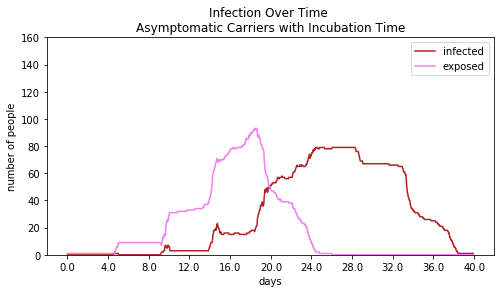

In [64]:
_ = plt.figure(figsize=(8, 4))
_ = plt.plot(asympt_df['time'], asympt_df['infected'], 
             color='firebrick', label='infected')
_ = plt.plot(asympt_df['time'], asympt_df['exposed'], 
         color='violet', label='exposed')
_ = plt.ylabel('number of people')
_ = plt.xlabel('days')
_ = plt.title('Infection Over Time \n'+
              'Asymptomatic Carriers with Incubation Time')
_ = plt.legend()
_ = plt.xticks(np.linspace(0, len(asympt_df[['time']]), 11), np.linspace(0, 40, 11))
_ = plt.ylim([0, 160])
plt.show()

Mean: 34.7875
Standard deviation: 31.73432437834466


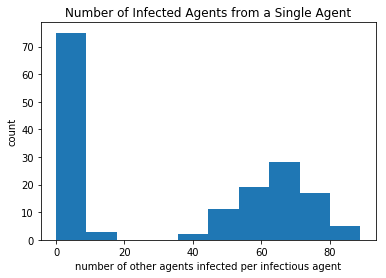

In [65]:
num_mean = agents["num infected"].mean()
print(f'Mean: {num_mean}')
num_std = agents["num infected"].std()
print(f'Standard deviation: {num_std}')
_ = plt.hist(agents['num infected'])
_ = plt.xlabel('number of other agents infected per infectious agent')
_ = plt.ylabel('count')
_ = plt.title('Number of Infected Agents from a Single Agent')
plt.show()

Testing velocity = 0.05
0.0% done
0.0% done
10.0% done
Testing velocity = 0.1
0.0% done
0.0% done
10.0% done
Testing velocity = 0.15
0.0% done
0.0% done
10.0% done
Testing velocity = 0.2
0.0% done
0.0% done
10.0% done
Testing velocity = 0.25
0.0% done
0.0% done
10.0% done
Testing velocity = 0.3
0.0% done
0.0% done
10.0% done
Testing velocity = 0.35
0.0% done
0.0% done
10.0% done
Testing velocity = 0.39999999999999997
0.0% done
0.0% done
10.0% done
Testing velocity = 0.44999999999999996
0.0% done
0.0% done
10.0% done
Testing velocity = 0.49999999999999994
0.0% done
0.0% done
10.0% done
Testing velocity = 0.5499999999999999
0.0% done
0.0% done
10.0% done
Testing velocity = 0.6
0.0% done
0.0% done
10.0% done


KeyboardInterrupt: 

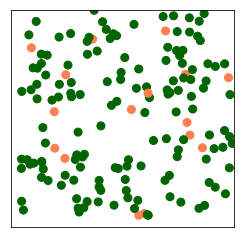

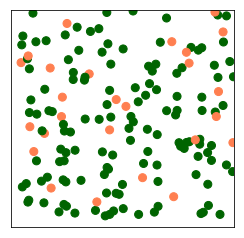

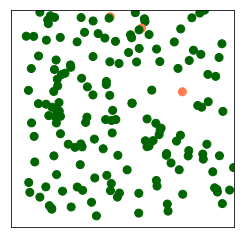

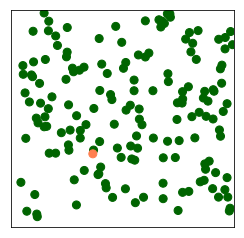

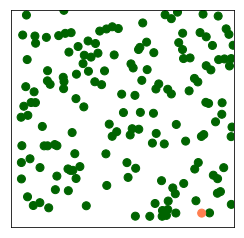

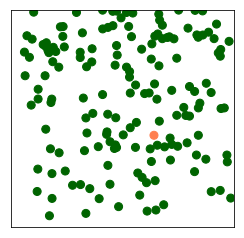

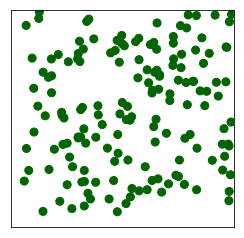

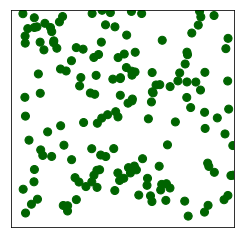

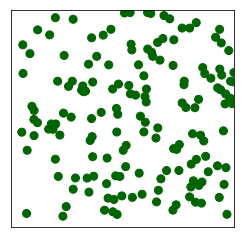

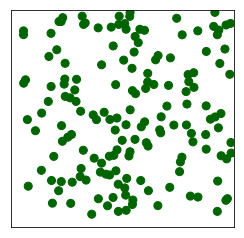

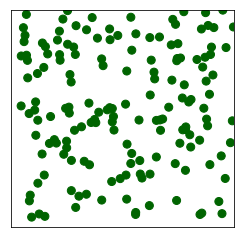

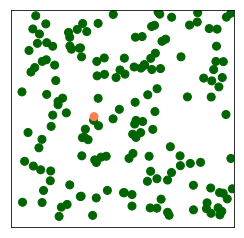

In [80]:
# Iterate over possible velocities
velos = {}
for v in np.linspace(.05, 2, 40):
    print(f'Testing velocity = {v}')
    # Name the datafile
    run_name = 'velo_test_' + str(v)
    dataname = '../../data/' + run_name + '.csv'
    f = open(dataname, 'w')
    # Write header of the file
    f.write('# Data from simulation of 200 agents with various levels\
     of sheltering or mask usage\n')
    f.write('time,percent sheltering,percent wearing masks,infected,\
    exposed,recovered,infected with mask,susceptible with mask,\
    infected symptomatic,infected asymptomatic\n')


    """Values of the simulation"""
    # Fixing random state for reproducibility
    np.random.seed(42)

    # Figure ratio
    fig_rat = .2
    # Set boundaries
    xboundaries = [0, 50 * fig_rat]
    yboundaries = [0, 50 * fig_rat]
    xmax, ymax = xboundaries[1]+.5 , yboundaries[1]+.5

    # Number of steps
    N_steps = 960
    # Number of agents
    n_agents = int(4000 * round(fig_rat ** 2, 2))
    # Set delta t
    dt = 1
    # Set velocity
    velo = v
    # Set percent of sheltering in place
    per_shelt = 0
    # Set percent of masked agents
    per_mask = 0

    # Define the array of agents with given properties
    agents = np.zeros(n_agents, dtype=[('position', float, 2),
                                       ('velocity', float, 2),
                                       ('color', str, 20),
                                       ('state', str, 20),
                                       ('time', int, 1),
                                       ('symptomatic', int, 1),
                                       ('num infected', int, 1),
                                       ('mask', bool, 1),
                                       ('touch', int, 1)])



    """Calculate initial values of agents"""
    # Define the initial random positions within the figure
    agents['position'] = np.random.uniform(0, xmax, (n_agents, 2))
    # Define the initial velocity angles
    init_angles = np.random.uniform(0, 2 * np.pi, n_agents)
    # Get initial x and y velocities from angles
    velocities = np.array([[np.sin(x), np.cos(x)] for x in init_angles]) 
    velocities *= velo
    # Get percentage of agents 'sheltering'
    num_shelt = int(per_shelt * n_agents)
    # Make sheltering agents static (if any)
    velocities[:num_shelt] = np.zeros((num_shelt, 2))
    # Number of hours for asymptomatic incubation
    asympt_incubate = 24 * 5.1
    # Number of hours for symptomatic incubation
    sympt_incubate = 24 * 4.6
    # Number of hours for asymptomatic infection
    asympt_infect = 14*24
    # Number of hours for symptomatic infection
    sympt_infect = 12
    # Define values for infection gamma pdf
    g_shape, g_scale = 0.25, 4
    # Probability reduction for asymptomatic carrier
    asym_prob = .66


    """Assign values to agents"""
    # Assign velocities
    agents['velocity'] = velocities
    # Assign color (Navy is the default susceptible agent)
    agents['color'] = np.array(['Navy'] * n_agents)
    # Set agents to be symptomatic
    agents['state'] = np.array(['Susceptible'] * n_agents)
    agents['time'] = np.array([0] * n_agents)
    n_mask = [True] * per_mask + [False] * (10-per_mask)
    agents['mask'] = np.random.choice(n_mask, n_agents, replace=True)
    agents['color'][agents['mask'] == True] = 'Dodgerblue'
    agents['symptomatic'] = np.zeros(n_agents)
    agents['num infected'] = np.zeros(n_agents)

    # Make the one agent infected
    agents['color'][0] = 'Violet'
    agents['state'][0] = 'Exposed'
    agents['time'][0] = 1
    agents['mask'][0] = False
    agents['symptomatic'][0] = 1


    """Define the values of the display"""
    # Define the figure
    fig = plt.figure(figsize=(20 * fig_rat, 20 * fig_rat))
    ax = plt.axes(xlim=(-.5, xmax), ylim=(-.5, ymax))
    plt.xticks([])
    plt.yticks([])

    # Initialize the plot
    scatter = ax.scatter(agents['position'][:, 0], 
                         agents['position'][:, 1],
                         color=agents['color'],
                         s=64)

    def update(i):
        """
        Take the information from the data stored in the agents array
        to calculate if an infected agent recovers, if two agents 
        interact, and if the agent bounces off a boundary
        """

        if i % int(N_steps / 2) == 0:
            print(str(i / int(N_steps / 2) * 10) + '% done')

        # Iterate over all agents 
        for j in range(n_agents):
            if agents['time'][j] != 0:
                # Calculate if agent is exposed or infected
                agent_j_infected = agents['state'][j] == 'Infected'
                agent_j_exposed = agents['state'][j] == 'Exposed'
                # Store time agent has been in this state
                agent_j_time = agents['time'][j]
                # Calculate if the agent is symptomatic or not
                agent_j_sympt = agents['symptomatic'][j]
                if agent_j_infected and agent_j_sympt:
                    if agents['time'][j] >= sympt_infect:
                        agents['state'][j] = 'Recovered'
                        agents['color'][j] = 'Darkgreen'
                        agents['time'][j] = 1
                    else:
                        agents['time'][j] += 1
                elif agent_j_infected and not agent_j_sympt:
                    if agents['time'][j] >= asympt_infect:
                        agents['state'][j] = 'Recovered'
                        agents['color'][j] = 'Darkgreen'
                        agents['time'][j] = 1
                    else:
                        agents['time'][j] += 1
                elif agent_j_exposed and agent_j_sympt:
                    if agents['time'][j] >= sympt_incubate:
                        agents['state'][j] = 'Infected'
                        agents['color'][j] = 'Firebrick'
                        agents['time'][j] = 1
                    else:
                        agents['time'][j] += 1
                elif agent_j_exposed and not agent_j_sympt:
                    if agents['time'][j] >= asympt_incubate:
                        agents['state'][j] = 'Infected'
                        agents['color'][j] = 'Coral'
                        agents['time'][j] = 1
                    else:
                        agents['time'][j] += 1

            # New displacements (prior velocity times change in time)
            deltax_temp = dt * agents['velocity'][j, 0]
            deltay_temp = dt * agents['velocity'][j, 1]
            # New positions
            x = agents['position'][j, 0] + deltax_temp
            y = agents['position'][j, 1] + deltay_temp
            # Compute new velocity
            vx_temp = deltax_temp / dt
            vy_temp = deltay_temp / dt

            # Add interaction
            for k in range(n_agents):
                # Go through all other agents that could be interacted with
                if k != j:
                    # Compute components of distance
                    dx = agents['position'][j, 0] - agents['position'][k, 0]
                    dy = agents['position'][j, 1] - agents['position'][k, 1]
                    # Compute distance between agents
                    dist_temp = np.sqrt(dx ** 2 + dy ** 2)
                    # If distance of interaction is closer than both radii, collide
                    if dist_temp <= 1:
                        agents['touch'][j] += 1
                        # Calculate if agents are infected
                        agent_j_infected = agents['state'][j] == 'Infected'
                        agent_k_infected = agents['state'][k] == 'Infected'
                        # Calculate if agents have recovered
                        agent_k_recover = agents['state'][k] == 'Recovered'
                        # Calculate if agents are susceptible
                        agent_j_suscept = agents['state'][j] == 'Susceptible'
                        agent_k_suscept = agents['state'][k] == 'Susceptible'
                        # Calculate if agents are symptomatic
                        agent_j_sympt = agents['symptomatic'][j] == 1
                        # If agent j is infected and agent k is susceptible
                        if agent_j_infected:
                            if agent_j_sympt and agent_k_suscept:
                                # Calculate probability of infection
                                temp_gam = np.random.gamma(g_shape, g_scale)
                                if temp_gam >= 1:
                                    # Are the agents wearing masks
                                    agent_j_mask = agents['mask'][j] == True
                                    agent_k_mask = agents['mask'][k] == True
                                    # If the infected is not wearing a mask
                                    if not agent_j_mask and agent_k_mask:
                                        if np.random.random() >= .85:
                                            agents['state'][k] = 'Exposed'
                                            if np.random.random() >= .5:
                                                agents['symptomatic'][k] = 1
                                                agents['color'][k] = 'Violet'
                                                agents['num infected'][j] += 1
                                            else:
                                                agents['symptomatic'][k] = 0
                                                agents['color'][k] = 'Indigo'
                                            agents['time'][k] = 1

                                    # If the susceptible is wearing a mask
                                    elif agent_j_mask and not agent_k_mask:
                                        if np.random.random() >= .95:
                                            agents['state'][k] = 'Exposed'
                                            if np.random.random() >= .5:
                                                agents['symptomatic'][k] = 1
                                                agents['color'][k] = 'Violet'
                                                agents['num infected'][j] += 1
                                            else:
                                                agents['symptomatic'][k] = 0
                                                agents['color'][k] = 'Indigo'
                                            agents['time'][k] = 1

                                    # If neither are wearing masks
                                    elif not agent_j_mask and not agent_k_mask:
                                        agents['state'][k] = 'Exposed'
                                        if np.random.random() >= .5:
                                            agents['symptomatic'][k] = 1
                                            agents['color'][k] = 'Violet'
                                            agents['num infected'][j] += 1
                                        else:
                                            agents['symptomatic'][k] = 0
                                            agents['color'][k] = 'Indigo'
                                        agents['time'][k] = 1         
                            elif not agent_j_sympt and agent_k_suscept:
                                # Get the time that agent j has been infectious
                                agent_j_time = agents['time'][j]
                                # Normalize time to infectious period
                                agent_j_norm_time = agent_j_time / asympt_infect
                                # Define the probability of asymptomatic infect
                                temp_gam = np.random.gamma(g_shape, g_scale)
                                asympt_gam = temp_gam * asym_prob * agent_j_norm_time
                                if asympt_gam >=1:
                                    # Are the agents wearing masks
                                    agent_j_mask = agents['mask'][j] == True
                                    agent_k_mask = agents['mask'][k] == True

                                    # If the infected is not wearing a mask
                                    if not agent_j_mask and agent_k_mask:
                                        if np.random.random() >= .85:
                                            agents['state'][k] = 'Exposed'
                                            if np.random.random() >= .5:
                                                agents['symptomatic'][k] = 1
                                                agents['color'][k] = 'Violet'
                                                agents['num infected'][j] += 1
                                            else:
                                                agents['symptomatic'][k] = 0
                                                agents['color'][k] = 'Indigo'
                                            agents['time'][k] = 1

                                    # If the susceptible is wearing a mask
                                    elif agent_j_mask and not agent_k_mask:
                                        if np.random.random() >= .95:
                                            agents['state'][k] = 'Exposed'
                                            if np.random.random() >= .5:
                                                agents['symptomatic'][k] = 1
                                                agents['color'][k] = 'Violet'
                                                agents['num infected'][j] += 1
                                            else:
                                                agents['symptomatic'][k] = 0
                                                agents['color'][k] = 'Indigo'
                                            agents['time'][k] = 1

                                    # If neither are wearing masks
                                    elif not agent_j_mask and not agent_k_mask:
                                        agents['state'][k] = 'Exposed'
                                        if np.random.random() >= .5:
                                            agents['symptomatic'][k] = 1
                                            agents['color'][k] = 'Violet'
                                            agents['num infected'][j] += 1
                                        else:
                                            agents['symptomatic'][k] = 0
                                            agents['color'][k] = 'Indigo'
                                        agents['time'][k] = 1
                            # Calculate if infection would have occured
                            elif agent_j_sympt:
                                if agent_k_infected or agent_k_recover:
                                    # Get the time that agent j has been infectious
                                    agent_j_time = agents['time'][j]
                                    # Normalize time to infectious period
                                    agent_j_norm_time = agent_j_time / asympt_infect
                                    # Define the probability of asymptomatic infect
                                    temp_gam = np.random.gamma(g_shape, g_scale)
                                    asympt_gam = temp_gam * asym_prob * agent_j_norm_time
                                    if temp_gam >= 1:
                                        # Are the agents wearing masks
                                        agent_j_mask = agents['mask'][j] == True
                                        agent_k_mask = agents['mask'][k] == True
                                        # If the infected is not wearing a mask
                                        if not agent_j_mask and agent_k_mask:
                                            if np.random.random() >= .85/2:
                                                agents['num infected'][j] += 1
                                        # If the susceptible is wearing a mask
                                        elif agent_j_mask and not agent_k_mask:
                                            if np.random.random() >= .95/2:
                                                agents['num infected'][j] += 1
                                        # If neither are wearing masks
                                        elif not agent_j_mask and not agent_k_mask:
                                            if np.random.random() >= .5:
                                                agents['num infected'][j] += 1
                            elif not agent_j_sympt:
                                if agent_k_infected or agent_k_recover:
                                    # Get the time that agent j has been infectious
                                    agent_j_time = agents['time'][j]
                                    # Normalize time to infectious period
                                    agent_j_norm_time = agent_j_time / asympt_infect
                                    # Define the probability of asymptomatic infect
                                    temp_gam = np.random.gamma(g_shape, g_scale)
                                    asympt_gam = temp_gam * asym_prob * agent_j_norm_time
                                    if asympt_gam >=1:
                                        # Are the agents wearing masks
                                        agent_j_mask = agents['mask'][j] == True
                                        agent_k_mask = agents['mask'][k] == True
                                        # If the infected is not wearing a mask
                                        if not agent_j_mask and agent_k_mask:
                                            if np.random.random() >= .85/2:
                                                agents['num infected'][j] += 1
                                        # If the susceptible is wearing a mask
                                        elif agent_j_mask and not agent_k_mask:
                                            if np.random.random() >= .95/2:
                                                agents['num infected'][j] += 1
                                        # If neither are wearing masks
                                        elif not agent_j_mask and not agent_k_mask:
                                            if np.random.random() >= .5:
                                                agents['num infected'][j] += 1


            # Bounce agents off wall if projected position is beyond boundary conditions
            if x >= xmax:
                x = 2 * xmax - deltax_temp - agents['position'][j, 0]
                vx_temp *= -1
            elif x <= 0:
                x = - deltax_temp - agents['position'][j, 0]
                vx_temp *= -1
            elif y >= ymax:
                y = 2 * ymax - deltay_temp - agents['position'][j, 1]
                vy_temp *= -1
            elif y <= 0:
                y = - deltay_temp - agents['position'][j, 1]
                vy_temp *= -1

            # 
            agents['position'][j] = np.array([x, y])
            agents['velocity'][j, 0] = vx_temp
            agents['velocity'][j, 1] = vy_temp

            # Update the scatter collection, with the new colors, sizes and positions.
            scatter.set_color(agents['color'])
            scatter.set_offsets(agents['position'])

        # Get values of the current time step
        temp_infected = sum(agents['state']=='Infected')
        temp_recovered = sum(agents['state']=='Recovered')
        temp_infect_mask = sum(agents[agents['mask']==True]['state'] == 'Infected')
        temp_suscept_mask = sum(agents[agents['mask']==True]['state'] == 'Susceptible')
        temp_exposed = sum(agents['state']=='Exposed')
        temp_infect_sympt = sum(agents[agents['symptomatic']==1]['state'] == 'Infected')
        temp_infect_asympt = sum(agents[agents['symptomatic']==0]['state'] == 'Infected')
        temp_write = str(i) + ',' + str(round(per_shelt * .1, 1)) + ',' + \
                     str(round(per_mask * .1, 1)) + ',' + str(temp_infected)+ ',' \
                     + str(temp_exposed) + ',' + str(temp_recovered) + ',' + \
                     str(temp_infect_mask) + ',' + str(temp_suscept_mask) + ',' + \
                     str(temp_infect_sympt) + ',' + str(temp_infect_asympt) + '\n'
        # Save current data to a file
        f.write(temp_write)
    

    # Animate the simulation by iterating
    animation = FuncAnimation(fig, update, frames=N_steps, interval=20)
    temp_name = '../../data/' + run_name + '.gif'
    animation.save(temp_name, writer='imagemagick')
    velos[v] = agents["num infected"]
    f.close()

In [108]:
print(agents[agents['symptomatic'] == 1]['num infected'].mean())
print(agents[agents['symptomatic'] == 0]['num infected'].mean())

3.965909090909091
63.27777777777778


In [111]:
# Start with EDA of yesterday's simulated data
# Read in file
dataname = '../../data/velo_test/velo_test_0.15.csv'
asympt_df = pd.read_csv(dataname, header=1)
asympt_df.head()

,time,percent sheltering,percent wearing masks,infected,exposed,recovered,infected with mask,susceptible with mask,infected symptomatic,infected asymptomatic
0,0,0.0,0.0,0,1,0,0,0,0,0
1,0,0.0,0.0,0,1,0,0,0,0,0
2,1,0.0,0.0,0,1,0,0,0,0,0
3,2,0.0,0.0,0,1,0,0,0,0,0
4,3,0.0,0.0,0,1,0,0,0,0,0


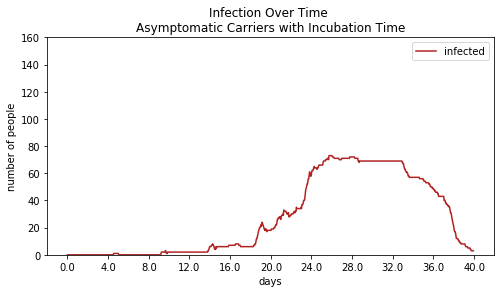

In [113]:
_ = plt.figure(figsize=(8, 4))
_ = plt.plot(asympt_df['time'], asympt_df['infected'], 
             color='firebrick', label='infected')
_ = plt.ylabel('number of people')
_ = plt.xlabel('days')
_ = plt.title('Infection Over Time \n'+
              'Asymptomatic Carriers with Incubation Time')
_ = plt.legend()
_ = plt.xticks(np.linspace(0, len(asympt_df[['time']]), 11), np.linspace(0, 40, 11))
_ = plt.ylim([0, 160])
plt.show()

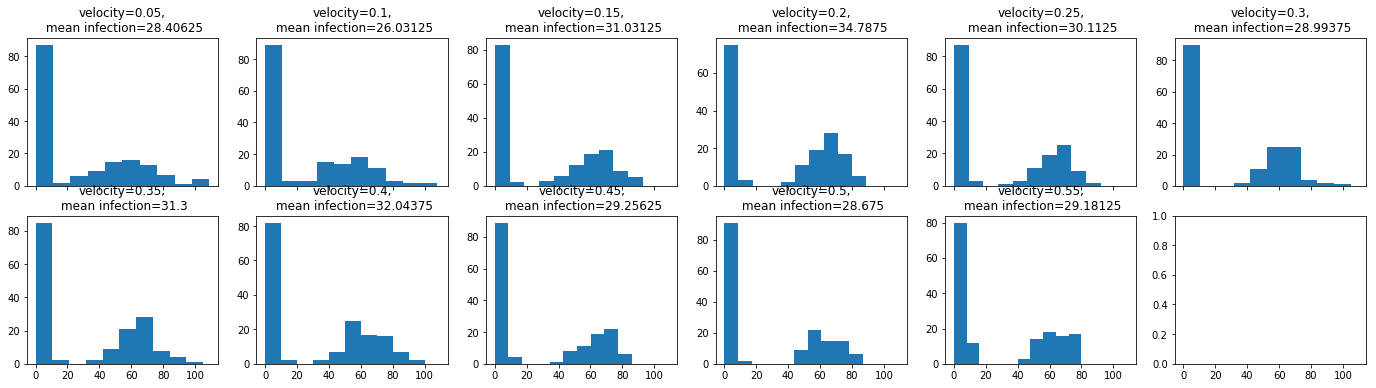

In [104]:
fig, ax = plt.subplots(2, 6, figsize=(24, 6), sharex=True)
for i, key in enumerate(velos.keys()):
    if i >= 6:
        ax_1 = 1
        ax_2 = i - 6
        ax[ax_1, ax_2].hist(velos[key])
        ax[ax_1, ax_2].set_title(f'velocity={round(key, 2)},\n mean infection={velos[key].mean()}')
        
    else:
        ax[0, i].set_title(f'velocity={round(key, 2)},\n mean infection={velos[key].mean()}')
        ax[0, i].hist(velos[key])

It appears that velocity does not change the number of interactions.

0.0% done
0.0% done
10.0% done
20.0% done
30.0% done
40.0% done
50.0% done
60.0% done
70.0% done
80.0% done
90.0% done
0.0% done


Traceback (most recent call last):
  File "/Users/adam/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 215, in process
    func(*args, **kwargs)
  File "/Users/adam/anaconda3/lib/python3.7/site-packages/matplotlib/animation.py", line 999, in _start
    self._init_draw()
  File "/Users/adam/anaconda3/lib/python3.7/site-packages/matplotlib/animation.py", line 1740, in _init_draw
    self._draw_frame(next(self.new_frame_seq()))
  File "/Users/adam/anaconda3/lib/python3.7/site-packages/matplotlib/animation.py", line 1762, in _draw_frame
    self._drawn_artists = self._func(framedata, *self._args)
  File "<ipython-input-134-172112149679>", line 378, in update
    f.write(temp_write)
ValueError: I/O operation on closed file.


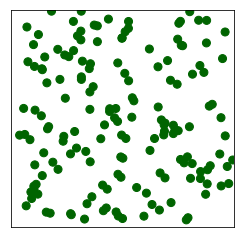

In [134]:
# Name the datafile
run_name = 'density_test_01'
dataname = '../../data/' + run_name + '.csv'
f = open(dataname, 'w')
# Write header of the file
f.write('# Data from simulation of 200 agents with various levels\
 of sheltering or mask usage\n')
f.write('time,percent sheltering,percent wearing masks,infected,\
exposed,recovered,infected with mask,susceptible with mask,\
infected symptomatic,infected asymptomatic\n')

        
"""Values of the simulation"""
# Fixing random state for reproducibility
np.random.seed(100)

# Figure ratio
fig_rat = .2
# Set boundaries
xboundaries = [0, 80 * fig_rat]
yboundaries = [0, 80 * fig_rat]
xmax, ymax = xboundaries[1]+.5 , yboundaries[1]+.5

# Number of steps
N_steps = 960
# Number of agents
n_agents = int(4000 * round(fig_rat ** 2, 2))
# Set delta t
dt = 1
# Set velocity
velo = .15
# Set percent of sheltering in place
per_shelt = 0
# Set percent of masked agents
per_mask = 0

# Define the array of agents with given properties
agents = np.zeros(n_agents, dtype=[('position', float, 2),
                                   ('velocity', float, 2),
                                   ('color', str, 20),
                                   ('state', str, 20),
                                   ('time', int, 1),
                                   ('symptomatic', int, 1),
                                   ('num infected', int, 1),
                                   ('mask', bool, 1),
                                   ('touch', int, 1)])



"""Calculate initial values of agents"""
# Define the initial random positions within the figure
agents['position'] = np.random.uniform(0, xmax, (n_agents, 2))
# Define the initial velocity angles
init_angles = np.random.uniform(0, 2 * np.pi, n_agents)
# Get initial x and y velocities from angles
velocities = np.array([[np.sin(x), np.cos(x)] for x in init_angles]) 
velocities *= velo
# Get percentage of agents 'sheltering'
num_shelt = int(per_shelt * n_agents)
# Make sheltering agents static (if any)
velocities[:num_shelt] = np.zeros((num_shelt, 2))
# Number of hours for asymptomatic incubation
asympt_incubate = 24 * 5.1
# Number of hours for symptomatic incubation
sympt_incubate = 24 * 4.6
# Number of hours for asymptomatic infection
asympt_infect = 7*24
# Number of hours for symptomatic infection
sympt_infect = 12
# Define values for infection gamma pdf
g_shape, g_scale = 0.25, 4
# Probability reduction for asymptomatic carrier
asym_prob = .66


"""Assign values to agents"""
# Assign velocities
agents['velocity'] = velocities
# Assign color (Navy is the default susceptible agent)
agents['color'] = np.array(['Navy'] * n_agents)
# Set agents to be symptomatic
agents['state'] = np.array(['Susceptible'] * n_agents)
agents['time'] = np.array([0] * n_agents)
n_mask = [True] * per_mask + [False] * (10-per_mask)
agents['mask'] = np.random.choice(n_mask, n_agents, replace=True)
agents['color'][agents['mask'] == True] = 'Dodgerblue'
agents['symptomatic'] = np.zeros(n_agents)
agents['num infected'] = np.zeros(n_agents)

# Make the one agent infected
agents['color'][0] = 'Violet'
agents['state'][0] = 'Exposed'
agents['time'][0] = 1
agents['mask'][0] = False
agents['symptomatic'][0] = 1


"""Define the values of the display"""
# Define the figure
fig = plt.figure(figsize=(20 * fig_rat, 20 * fig_rat))
ax = plt.axes(xlim=(-.5, xmax), ylim=(-.5, ymax))
plt.xticks([])
plt.yticks([])

# Initialize the plot
scatter = ax.scatter(agents['position'][:, 0], 
                     agents['position'][:, 1],
                     color=agents['color'],
                     s=64)

def update(i):
    """
    Take the information from the data stored in the agents array
    to calculate if an infected agent recovers, if two agents 
    interact, and if the agent bounces off a boundary
    """
    
    if i % int(N_steps / 10) == 0:
        print(str(i / int(N_steps / 10) * 10) + '% done')

    # Iterate over all agents 
    for j in range(n_agents):
        if agents['time'][j] != 0:
            # Calculate if agent is exposed or infected
            agent_j_infected = agents['state'][j] == 'Infected'
            agent_j_exposed = agents['state'][j] == 'Exposed'
            # Store time agent has been in this state
            agent_j_time = agents['time'][j]
            # Calculate if the agent is symptomatic or not
            agent_j_sympt = agents['symptomatic'][j]
            if agent_j_infected and agent_j_sympt and :
                if agents['time'][j] >= sympt_infect:
                    if agents['color'][j] == 'Firebrick':
                        agents['state'][j] = 'Infected'
                        agents['color'][j] = 'Darkgreen'
                        agents['time'][j] = 1
                    else:
                        if agents['time'][j] > 14*24:
                            agents['time'][j] = 0
                            agents['state'][j] = 'Recovered'
                        else:
                            agents['time'][j] +=1
                else:
                    agents['time'][j] += 1
            elif agent_j_infected and not agent_j_sympt:
                if agents['time'][j] >= asympt_infect:
                    agents['state'][j] = 'Recovered'
                    agents['color'][j] = 'Darkgreen'
                    agents['time'][j] = 1
                else:
                    agents['time'][j] += 1
            elif agent_j_exposed and agent_j_sympt:
                if agents['time'][j] >= sympt_incubate:
                    agents['state'][j] = 'Infected'
                    agents['color'][j] = 'Firebrick'
                    agents['time'][j] = 1
                else:
                    agents['time'][j] += 1
            elif agent_j_exposed and not agent_j_sympt:
                if agents['time'][j] >= asympt_incubate:
                    agents['state'][j] = 'Infected'
                    agents['color'][j] = 'Coral'
                    agents['time'][j] = 1
                else:
                    agents['time'][j] += 1
                
        # New displacements (prior velocity times change in time)
        deltax_temp = dt * agents['velocity'][j, 0]
        deltay_temp = dt * agents['velocity'][j, 1]
        # New positions
        x = agents['position'][j, 0] + deltax_temp
        y = agents['position'][j, 1] + deltay_temp
        # Compute new velocity
        vx_temp = deltax_temp / dt
        vy_temp = deltay_temp / dt

        # Add interaction
        for k in range(n_agents):
            # Go through all other agents that could be interacted with
            if k != j:
                # Compute components of distance
                dx = agents['position'][j, 0] - agents['position'][k, 0]
                dy = agents['position'][j, 1] - agents['position'][k, 1]
                # Compute distance between agents
                dist_temp = np.sqrt(dx ** 2 + dy ** 2)
                # If distance of interaction is closer than both radii, collide
                if dist_temp <= 1:
                    agents['touch'][j] += 1
                    # Calculate if agents are infected
                    agent_j_infected = agents['state'][j] == 'Infected'
                    agent_k_infected = agents['state'][k] == 'Infected'
                    # Calculate if agents have recovered
                    agent_k_recover = agents['state'][k] == 'Recovered'
                    # Calculate if agents are susceptible
                    agent_j_suscept = agents['state'][j] == 'Susceptible'
                    agent_k_suscept = agents['state'][k] == 'Susceptible'
                    # Calculate if agents are symptomatic
                    agent_j_sympt = agents['symptomatic'][j] == 1
                    # If agent j is infected and agent k is susceptible
                    if agent_j_infected:
                        if agent_j_sympt and agent_k_suscept:
                            # Calculate probability of infection
                            temp_gam = np.random.gamma(g_shape, g_scale)
                            if temp_gam >= 1:
                                # Are the agents wearing masks
                                agent_j_mask = agents['mask'][j] == True
                                agent_k_mask = agents['mask'][k] == True
                                # If the infected is not wearing a mask
                                if not agent_j_mask and agent_k_mask:
                                    if np.random.random() >= .85:
                                        agents['state'][k] = 'Exposed'
                                        if np.random.random() >= .5:
                                            agents['symptomatic'][k] = 1
                                            agents['color'][k] = 'Violet'
                                            agents['num infected'][j] += 1
                                        else:
                                            agents['symptomatic'][k] = 0
                                            agents['color'][k] = 'Indigo'
                                        agents['time'][k] = 1
                                        
                                # If the susceptible is wearing a mask
                                elif agent_j_mask and not agent_k_mask:
                                    if np.random.random() >= .95:
                                        agents['state'][k] = 'Exposed'
                                        if np.random.random() >= .5:
                                            agents['symptomatic'][k] = 1
                                            agents['color'][k] = 'Violet'
                                            agents['num infected'][j] += 1
                                        else:
                                            agents['symptomatic'][k] = 0
                                            agents['color'][k] = 'Indigo'
                                        agents['time'][k] = 1
                                        
                                # If neither are wearing masks
                                elif not agent_j_mask and not agent_k_mask:
                                    agents['state'][k] = 'Exposed'
                                    if np.random.random() >= .5:
                                        agents['symptomatic'][k] = 1
                                        agents['color'][k] = 'Violet'
                                        agents['num infected'][j] += 1
                                    else:
                                        agents['symptomatic'][k] = 0
                                        agents['color'][k] = 'Indigo'
                                    agents['time'][k] = 1         
                        elif not agent_j_sympt and agent_k_suscept:
                            # Get the time that agent j has been infectious
                            agent_j_time = agents['time'][j]
                            # Normalize time to infectious period
                            agent_j_norm_time = agent_j_time / asympt_infect
                            # Define the probability of asymptomatic infect
                            temp_gam = np.random.gamma(g_shape, g_scale)
                            asympt_gam = temp_gam * asym_prob * agent_j_norm_time
                            if asympt_gam >=1:
                                # Are the agents wearing masks
                                agent_j_mask = agents['mask'][j] == True
                                agent_k_mask = agents['mask'][k] == True

                                # If the infected is not wearing a mask
                                if not agent_j_mask and agent_k_mask:
                                    if np.random.random() >= .85:
                                        agents['state'][k] = 'Exposed'
                                        if np.random.random() >= .5:
                                            agents['symptomatic'][k] = 1
                                            agents['color'][k] = 'Violet'
                                            agents['num infected'][j] += 1
                                        else:
                                            agents['symptomatic'][k] = 0
                                            agents['color'][k] = 'Indigo'
                                        agents['time'][k] = 1
                                        
                                # If the susceptible is wearing a mask
                                elif agent_j_mask and not agent_k_mask:
                                    if np.random.random() >= .95:
                                        agents['state'][k] = 'Exposed'
                                        if np.random.random() >= .5:
                                            agents['symptomatic'][k] = 1
                                            agents['color'][k] = 'Violet'
                                            agents['num infected'][j] += 1
                                        else:
                                            agents['symptomatic'][k] = 0
                                            agents['color'][k] = 'Indigo'
                                        agents['time'][k] = 1
                                        
                                # If neither are wearing masks
                                elif not agent_j_mask and not agent_k_mask:
                                    agents['state'][k] = 'Exposed'
                                    if np.random.random() >= .5:
                                        agents['symptomatic'][k] = 1
                                        agents['color'][k] = 'Violet'
                                        agents['num infected'][j] += 1
                                    else:
                                        agents['symptomatic'][k] = 0
                                        agents['color'][k] = 'Indigo'
                                    agents['time'][k] = 1
                        # Calculate if infection would have occured
                        elif agent_j_sympt:
                            if agent_k_infected or agent_k_recover:
                                # Get the time that agent j has been infectious
                                agent_j_time = agents['time'][j]
                                # Normalize time to infectious period
                                agent_j_norm_time = agent_j_time / asympt_infect
                                # Define the probability of asymptomatic infect
                                temp_gam = np.random.gamma(g_shape, g_scale)
                                asympt_gam = temp_gam * asym_prob * agent_j_norm_time
                                if temp_gam >= 1:
                                    # Are the agents wearing masks
                                    agent_j_mask = agents['mask'][j] == True
                                    agent_k_mask = agents['mask'][k] == True
                                    # If the infected is not wearing a mask
                                    if not agent_j_mask and agent_k_mask:
                                        if np.random.random() >= .85/2:
                                            agents['num infected'][j] += 1
                                    # If the susceptible is wearing a mask
                                    elif agent_j_mask and not agent_k_mask:
                                        if np.random.random() >= .95/2:
                                            agents['num infected'][j] += 1
                                    # If neither are wearing masks
                                    elif not agent_j_mask and not agent_k_mask:
                                        if np.random.random() >= .5:
                                            agents['num infected'][j] += 1
                        elif not agent_j_sympt:
                            if agent_k_infected or agent_k_recover:
                                # Get the time that agent j has been infectious
                                agent_j_time = agents['time'][j]
                                # Normalize time to infectious period
                                agent_j_norm_time = agent_j_time / asympt_infect
                                # Define the probability of asymptomatic infect
                                temp_gam = np.random.gamma(g_shape, g_scale)
                                asympt_gam = temp_gam * asym_prob * agent_j_norm_time
                                if asympt_gam >=1:
                                    # Are the agents wearing masks
                                    agent_j_mask = agents['mask'][j] == True
                                    agent_k_mask = agents['mask'][k] == True
                                    # If the infected is not wearing a mask
                                    if not agent_j_mask and agent_k_mask:
                                        if np.random.random() >= .85/2:
                                            agents['num infected'][j] += 1
                                    # If the susceptible is wearing a mask
                                    elif agent_j_mask and not agent_k_mask:
                                        if np.random.random() >= .95/2:
                                            agents['num infected'][j] += 1
                                    # If neither are wearing masks
                                    elif not agent_j_mask and not agent_k_mask:
                                        if np.random.random() >= .5:
                                            agents['num infected'][j] += 1
                                    
        
        # Bounce agents off wall if projected position is beyond boundary conditions
        if x >= xmax:
            x = 2 * xmax - deltax_temp - agents['position'][j, 0]
            vx_temp *= -1
        elif x <= 0:
            x = - deltax_temp - agents['position'][j, 0]
            vx_temp *= -1
        elif y >= ymax:
            y = 2 * ymax - deltay_temp - agents['position'][j, 1]
            vy_temp *= -1
        elif y <= 0:
            y = - deltay_temp - agents['position'][j, 1]
            vy_temp *= -1

        # 
        agents['position'][j] = np.array([x, y])
        agents['velocity'][j, 0] = vx_temp
        agents['velocity'][j, 1] = vy_temp

        # Update the scatter collection, with the new colors, sizes and positions.
        scatter.set_color(agents['color'])
        scatter.set_offsets(agents['position'])

    # Get values of the current time step
    temp_infected = sum(agents['state']=='Infected')
    temp_recovered = sum(agents['state']=='Recovered')
    temp_infect_mask = sum(agents[agents['mask']==True]['state'] == 'Infected')
    temp_suscept_mask = sum(agents[agents['mask']==True]['state'] == 'Susceptible')
    temp_exposed = sum(agents['state']=='Exposed')
    temp_infect_sympt = sum(agents[agents['symptomatic']==1]['state'] == 'Infected')
    temp_infect_asympt = sum(agents[agents['symptomatic']==0]['state'] == 'Infected')
    temp_write = str(i) + ',' + str(round(per_shelt * .1, 1)) + ',' + \
                 str(round(per_mask * .1, 1)) + ',' + str(temp_infected)+ ',' \
                 + str(temp_exposed) + ',' + str(temp_recovered) + ',' + \
                 str(temp_infect_mask) + ',' + str(temp_suscept_mask) + ',' + \
                 str(temp_infect_sympt) + ',' + str(temp_infect_asympt) + '\n'
    # Save current data to a file
    f.write(temp_write)

# Animate the simulation by iterating
animation = FuncAnimation(fig, update, frames=N_steps, interval=24)
temp_name = '../../data/' + run_name + '.gif'
animation.save(temp_name, writer='imagemagick')
f.close()

In [135]:
# Start with EDA of yesterday's simulated data
# Read in file
dataname = '../../data/density_test_01.csv'
asympt_df = pd.read_csv(dataname, header=1)
asympt_df.head()

,time,percent sheltering,percent wearing masks,infected,exposed,recovered,infected with mask,susceptible with mask,infected symptomatic,infected asymptomatic
0,0,0.0,0.0,0,1,0,0,0,0,0
1,0,0.0,0.0,0,1,0,0,0,0,0
2,1,0.0,0.0,0,1,0,0,0,0,0
3,2,0.0,0.0,0,1,0,0,0,0,0
4,3,0.0,0.0,0,1,0,0,0,0,0


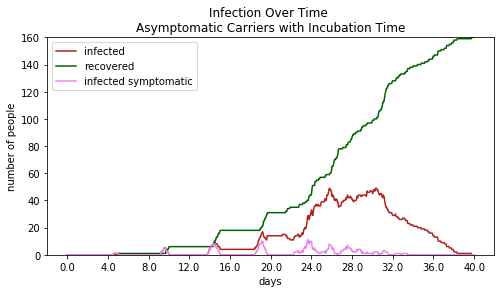

In [140]:
_ = plt.figure(figsize=(8, 4))
_ = plt.plot(asympt_df['time'], asympt_df['infected'], 
             color='firebrick', label='infected')
_ = plt.plot(asympt_df['time'], asympt_df['recovered'], 
             color='darkgreen', label='recovered')
_ = plt.plot(asympt_df['time'], asympt_df['infected symptomatic'], 
             color='violet', label='infected symptomatic')
_ = plt.ylabel('number of people')
_ = plt.xlabel('days')
_ = plt.title('Infection Over Time \n'+
              'Asymptomatic Carriers with Incubation Time')
_ = plt.legend()
_ = plt.xticks(np.linspace(0, len(asympt_df[['time']]), 11), np.linspace(0, 40, 11))
_ = plt.ylim([0, 160])
plt.show()

Mean: 6.40625
Standard deviation: 6.390712866144121


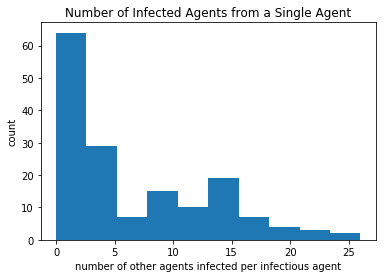

In [137]:
num_mean = agents["num infected"].mean()
print(f'Mean: {num_mean}')
num_std = agents["num infected"].std()
print(f'Standard deviation: {num_std}')
_ = plt.hist(agents['num infected'])
_ = plt.xlabel('number of other agents infected per infectious agent')
_ = plt.ylabel('count')
_ = plt.title('Number of Infected Agents from a Single Agent')
plt.show()

In [138]:
print(agents[agents['symptomatic'] == 1]['num infected'].mean())
print(agents[agents['symptomatic'] == 0]['num infected'].mean())

1.7078651685393258
12.295774647887324


Traceback (most recent call last):
  File "/Users/adam/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 215, in process
    func(*args, **kwargs)
  File "/Users/adam/anaconda3/lib/python3.7/site-packages/matplotlib/animation.py", line 999, in _start
    self._init_draw()
  File "/Users/adam/anaconda3/lib/python3.7/site-packages/matplotlib/animation.py", line 1740, in _init_draw
    self._draw_frame(next(self.new_frame_seq()))
  File "/Users/adam/anaconda3/lib/python3.7/site-packages/matplotlib/animation.py", line 1762, in _draw_frame
    self._drawn_artists = self._func(framedata, *self._args)
  File "<ipython-input-211-0f14c4bda5f5>", line 389, in update
    f.write(temp_write)
ValueError: I/O operation on closed file.


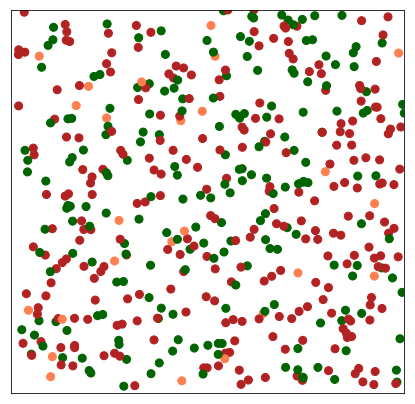

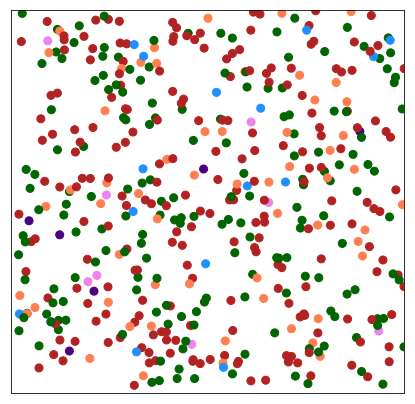

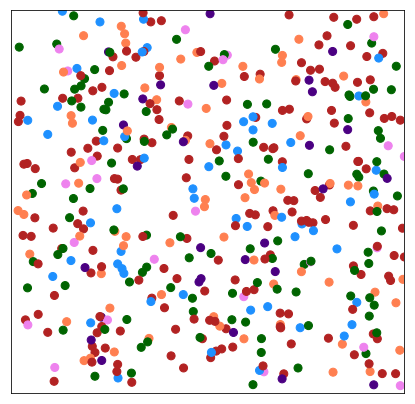

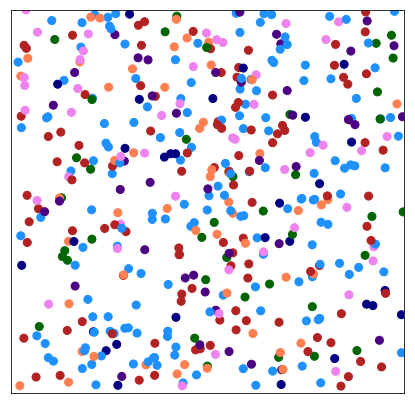

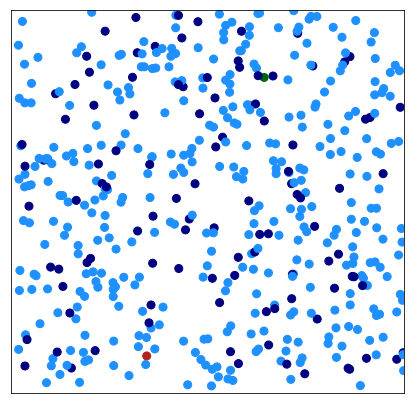

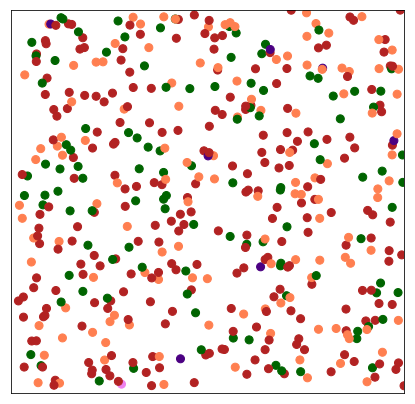

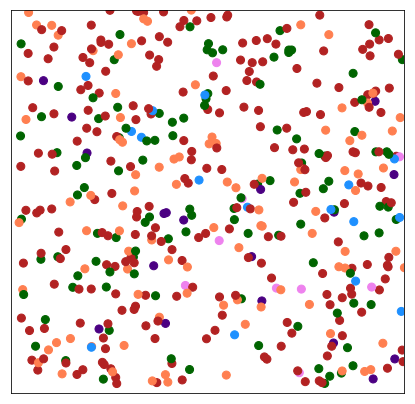

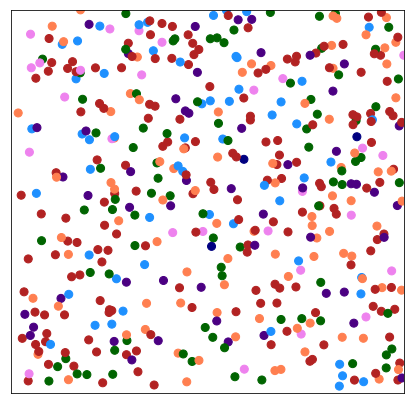

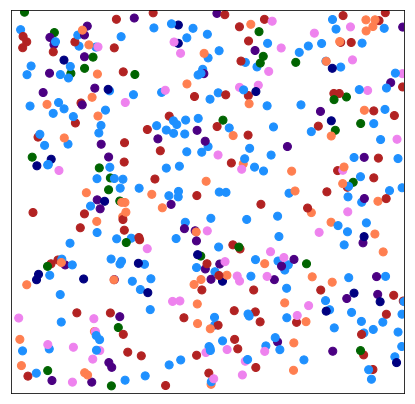

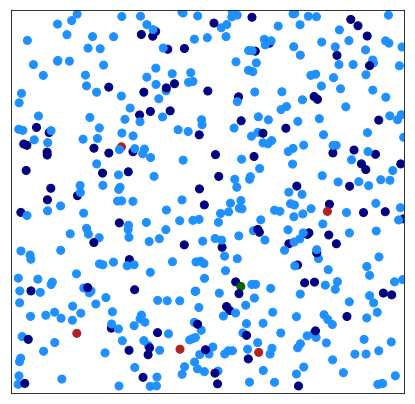

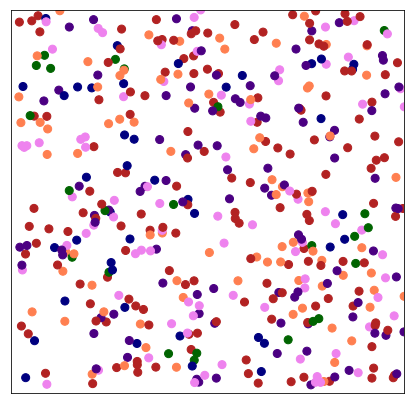

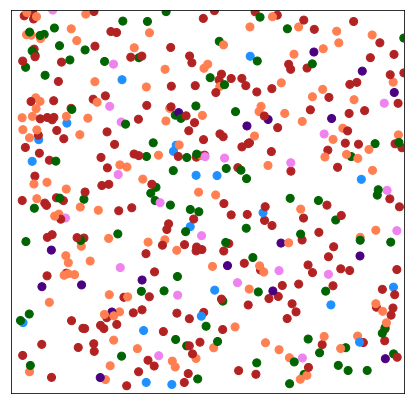

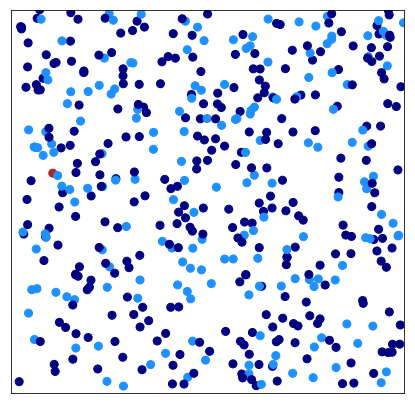

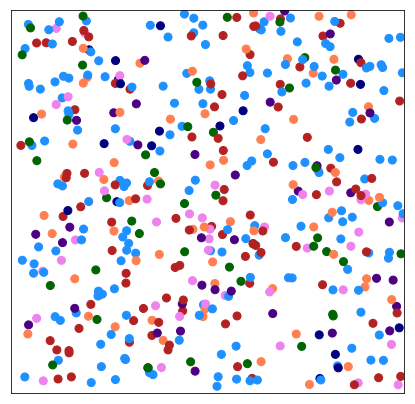

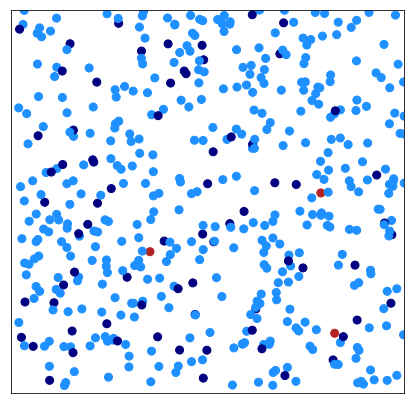

In [211]:
rand_num = 42
# Fixing random state for reproducibility
np.random.seed(rand_num)
for g in range(3):
    for h in range(5):
        # Name the datafile
        run_name = 'mask_per_0' + str(h * 2) + '_iter_' + str(g)
        dataname = '../../data/first_run/' + run_name + '.csv'
        f = open(dataname, 'w')
        # Write header of the file
        f.write('# Data from simulation of 200 agents with various levels\
         of sheltering or mask usage\n')
        f.write('time,percent sheltering,percent wearing masks,infected,\
exposed,recovered,infected with mask,susceptible with mask,\
infected symptomatic,infected asymptomatic\n')


        """Values of the simulation"""

        # Figure ratio
        fig_rat = .35355
        # Set boundaries
        xboundaries = [0, 75 * fig_rat]
        yboundaries = [0, 75 * fig_rat]
        xmax, ymax = xboundaries[1]+.5 , yboundaries[1]+.5

        # Number of steps
        N_steps = 960
        # Number of agents
        n_agents = int(4000 * round(fig_rat ** 2, 2))
        # Set delta t
        dt = 1
        # Set velocity
        velo = .15
        # Set percent of sheltering in place
        per_shelt = 0
        # Set percent of masked agents
        per_mask = int(h * 2)

        # Define the array of agents with given properties
        agents = np.zeros(n_agents, dtype=[('position', float, 2),
                                           ('velocity', float, 2),
                                           ('color', str, 20),
                                           ('state', str, 20),
                                           ('time', int, 1),
                                           ('symptomatic', int, 1),
                                           ('num infected', int, 1),
                                           ('mask', bool, 1),
                                           ('touch', int, 1)])



        """Calculate initial values of agents"""
        # Define the initial random positions within the figure
        agents['position'] = np.random.uniform(0, xmax, (n_agents, 2))
        # Define the initial velocity angles
        init_angles = np.random.uniform(0, 2 * np.pi, n_agents)
        # Get initial x and y velocities from angles
        velocities = np.array([[np.sin(x), np.cos(x)] for x in init_angles]) 
        velocities *= velo
        # Get percentage of agents 'sheltering'
        num_shelt = int(per_shelt * n_agents)
        # Make sheltering agents static (if any)
        velocities[:num_shelt] = np.zeros((num_shelt, 2))
        # Number of hours for asymptomatic incubation
        asympt_incubate = 24 * 5.1
        # Number of hours for symptomatic incubation
        sympt_incubate = 24 * 4.6
        # Number of hours for asymptomatic infection
        asympt_infect = 7*24
        # Number of hours for symptomatic infection
        sympt_infect = 12
        # Define values for infection gamma pdf
        g_shape, g_scale = 0.25, 4
        # Probability reduction for asymptomatic carrier
        asym_prob = .66


        """Assign values to agents"""
        # Assign velocities
        agents['velocity'] = velocities
        # Assign color (Navy is the default susceptible agent)
        agents['color'] = np.array(['Navy'] * n_agents)
        # Set agents to be symptomatic
        agents['state'] = np.array(['Susceptible'] * n_agents)
        agents['time'] = np.array([0] * n_agents)
        n_mask = [True] * per_mask + [False] * (10-per_mask)
        agents['mask'] = np.random.choice(n_mask, n_agents, replace=True)
        agents['color'][agents['mask'] == True] = 'Dodgerblue'
        agents['symptomatic'] = np.zeros(n_agents)
        agents['num infected'] = np.zeros(n_agents)

        # Make the one agent infected
        agents['color'][0] = 'Violet'
        agents['state'][0] = 'Exposed'
        agents['time'][0] = 1
        agents['mask'][0] = False
        agents['symptomatic'][0] = 1


        """Define the values of the display"""
        # Define the figure
        fig = plt.figure(figsize=(20 * fig_rat, 20 * fig_rat))
        ax = plt.axes(xlim=(-.5, xmax), ylim=(-.5, ymax))
        plt.xticks([])
        plt.yticks([])

        # Initialize the plot
        scatter = ax.scatter(agents['position'][:, 0], 
                             agents['position'][:, 1],
                             color=agents['color'],
                             s=64)

        def update(i):
            """
            Take the information from the data stored in the agents array
            to calculate if an infected agent recovers, if two agents 
            interact, and if the agent bounces off a boundary
            """
            #print(i)
            #if i % int(N_steps / 10) == 0:
            #    print(str(i / int(N_steps / 10) * 10) + '% done')

            # Iterate over all agents 
            for j in range(n_agents):
                if agents['time'][j] != 0:
                    # Calculate if agent is exposed or infected
                    agent_j_infected = agents['state'][j] == 'Infected'
                    agent_j_exposed = agents['state'][j] == 'Exposed'
                    # Store time agent has been in this state
                    agent_j_time = agents['time'][j]
                    # Calculate if the agent is symptomatic or not
                    agent_j_sympt = agents['symptomatic'][j]
                    if agent_j_infected and agent_j_sympt:
                        if agents['time'][j] >= sympt_infect:
                            if agents['color'][j] == 'Firebrick':
                                agents['state'][j] = 'Recovered'
                                agents['color'][j] = 'Firebrick'
                                agents['time'][j] = 1
                        else:
                            agents['time'][j] += 1
                    elif agent_j_infected and not agent_j_sympt:
                        if agents['time'][j] >= asympt_infect:
                            agents['state'][j] = 'Recovered'
                            agents['color'][j] = 'Darkgreen'
                            agents['time'][j] = 1
                        else:
                            agents['time'][j] += 1
                    elif agent_j_exposed and agent_j_sympt:
                        if agents['time'][j] >= sympt_incubate:
                            agents['state'][j] = 'Infected'
                            agents['color'][j] = 'Firebrick'
                            agents['time'][j] = 1
                        else:
                            agents['time'][j] += 1
                    elif agent_j_exposed and not agent_j_sympt:
                        if agents['time'][j] >= asympt_incubate:
                            agents['state'][j] = 'Infected'
                            agents['color'][j] = 'Coral'
                            agents['time'][j] = 1
                        else:
                            agents['time'][j] += 1
                    elif agents['state'][j] == 'Recovered' and agents['symptomatic'][j] == 1:
                        if agents['time'][j] > 14*24:
                            agents['time'][j] = 0
                            agents['state'][j] = 'Recovered'

                        else:
                            agents['time'][j] +=1

                # New displacements (prior velocity times change in time)
                deltax_temp = dt * agents['velocity'][j, 0]
                deltay_temp = dt * agents['velocity'][j, 1]
                # New positions
                x = agents['position'][j, 0] + deltax_temp
                y = agents['position'][j, 1] + deltay_temp
                # Compute new velocity
                vx_temp = deltax_temp / dt
                vy_temp = deltay_temp / dt

                # Add interaction
                for k in range(n_agents):
                    # Go through all other agents that could be interacted with
                    if k != j:
                        # Compute components of distance
                        dx = agents['position'][j, 0] - agents['position'][k, 0]
                        dy = agents['position'][j, 1] - agents['position'][k, 1]
                        # Compute distance between agents
                        dist_temp = np.sqrt(dx ** 2 + dy ** 2)
                        # If distance of interaction is closer than both radii, collide
                        if dist_temp <= 1:
                            agents['touch'][j] += 1
                            # Calculate if agents are infected
                            agent_j_infected = agents['state'][j] == 'Infected'
                            agent_k_infected = agents['state'][k] == 'Infected'
                            # Calculate if agents have recovered
                            agent_k_recover = agents['state'][k] == 'Recovered'
                            # Calculate if agents are susceptible
                            agent_j_suscept = agents['state'][j] == 'Susceptible'
                            agent_k_suscept = agents['state'][k] == 'Susceptible'
                            # Calculate if agents are symptomatic
                            agent_j_sympt = agents['symptomatic'][j] == 1
                            # If agent j is infected and agent k is susceptible
                            if agent_j_infected:
                                if agent_j_sympt and agent_k_suscept:
                                    # Calculate probability of infection
                                    temp_gam = np.random.gamma(g_shape, g_scale)
                                    if temp_gam >= 1:
                                        # Are the agents wearing masks
                                        agent_j_mask = agents['mask'][j] == True
                                        agent_k_mask = agents['mask'][k] == True
                                        # If the infected is not wearing a mask
                                        if not agent_j_mask and agent_k_mask:
                                            if np.random.random() >= .85:
                                                agents['state'][k] = 'Exposed'
                                                if np.random.random() >= .5:
                                                    agents['symptomatic'][k] = 1
                                                    agents['color'][k] = 'Violet'
                                                    agents['num infected'][j] += 1
                                                else:
                                                    agents['symptomatic'][k] = 0
                                                    agents['color'][k] = 'Indigo'
                                                agents['time'][k] = 1

                                        # If the susceptible is wearing a mask
                                        elif agent_j_mask and not agent_k_mask:
                                            if np.random.random() >= .95:
                                                agents['state'][k] = 'Exposed'
                                                if np.random.random() >= .5:
                                                    agents['symptomatic'][k] = 1
                                                    agents['color'][k] = 'Violet'
                                                    agents['num infected'][j] += 1
                                                else:
                                                    agents['symptomatic'][k] = 0
                                                    agents['color'][k] = 'Indigo'
                                                agents['time'][k] = 1

                                        # If neither are wearing masks
                                        elif not agent_j_mask and not agent_k_mask:
                                            agents['state'][k] = 'Exposed'
                                            if np.random.random() >= .5:
                                                agents['symptomatic'][k] = 1
                                                agents['color'][k] = 'Violet'
                                                agents['num infected'][j] += 1
                                            else:
                                                agents['symptomatic'][k] = 0
                                                agents['color'][k] = 'Indigo'
                                            agents['time'][k] = 1         
                                elif not agent_j_sympt and agent_k_suscept:
                                    # Get the time that agent j has been infectious
                                    agent_j_time = agents['time'][j]
                                    # Normalize time to infectious period
                                    agent_j_norm_time = agent_j_time / asympt_infect
                                    # Define the probability of asymptomatic infect
                                    temp_gam = np.random.gamma(g_shape, g_scale)
                                    asympt_gam = temp_gam * asym_prob * agent_j_norm_time
                                    if asympt_gam >=1:
                                        # Are the agents wearing masks
                                        agent_j_mask = agents['mask'][j] == True
                                        agent_k_mask = agents['mask'][k] == True

                                        # If the infected is not wearing a mask
                                        if not agent_j_mask and agent_k_mask:
                                            if np.random.random() >= .85:
                                                agents['state'][k] = 'Exposed'
                                                if np.random.random() >= .5:
                                                    agents['symptomatic'][k] = 1
                                                    agents['color'][k] = 'Violet'
                                                    agents['num infected'][j] += 1
                                                else:
                                                    agents['symptomatic'][k] = 0
                                                    agents['color'][k] = 'Indigo'
                                                agents['time'][k] = 1

                                        # If the susceptible is wearing a mask
                                        elif agent_j_mask and not agent_k_mask:
                                            if np.random.random() >= .95:
                                                agents['state'][k] = 'Exposed'
                                                if np.random.random() >= .5:
                                                    agents['symptomatic'][k] = 1
                                                    agents['color'][k] = 'Violet'
                                                    agents['num infected'][j] += 1
                                                else:
                                                    agents['symptomatic'][k] = 0
                                                    agents['color'][k] = 'Indigo'
                                                agents['time'][k] = 1

                                        # If neither are wearing masks
                                        elif not agent_j_mask and not agent_k_mask:
                                            agents['state'][k] = 'Exposed'
                                            if np.random.random() >= .5:
                                                agents['symptomatic'][k] = 1
                                                agents['color'][k] = 'Violet'
                                                agents['num infected'][j] += 1
                                            else:
                                                agents['symptomatic'][k] = 0
                                                agents['color'][k] = 'Indigo'
                                            agents['time'][k] = 1
                                # Calculate if infection would have occured
                                elif agent_j_sympt:
                                    if agent_k_infected or agent_k_recover:
                                        # Get the time that agent j has been infectious
                                        agent_j_time = agents['time'][j]
                                        # Normalize time to infectious period
                                        agent_j_norm_time = agent_j_time / asympt_infect
                                        # Define the probability of asymptomatic infect
                                        temp_gam = np.random.gamma(g_shape, g_scale)
                                        asympt_gam = temp_gam * asym_prob * agent_j_norm_time
                                        if temp_gam >= 1:
                                            # Are the agents wearing masks
                                            agent_j_mask = agents['mask'][j] == True
                                            agent_k_mask = agents['mask'][k] == True
                                            # If the infected is not wearing a mask
                                            if not agent_j_mask and agent_k_mask:
                                                if np.random.random() >= .85/2:
                                                    agents['num infected'][j] += 1
                                            # If the susceptible is wearing a mask
                                            elif agent_j_mask and not agent_k_mask:
                                                if np.random.random() >= .95/2:
                                                    agents['num infected'][j] += 1
                                            # If neither are wearing masks
                                            elif not agent_j_mask and not agent_k_mask:
                                                if np.random.random() >= .5:
                                                    agents['num infected'][j] += 1
                                elif not agent_j_sympt:
                                    if agent_k_infected or agent_k_recover:
                                        # Get the time that agent j has been infectious
                                        agent_j_time = agents['time'][j]
                                        # Normalize time to infectious period
                                        agent_j_norm_time = agent_j_time / asympt_infect
                                        # Define the probability of asymptomatic infect
                                        temp_gam = np.random.gamma(g_shape, g_scale)
                                        asympt_gam = temp_gam * asym_prob * agent_j_norm_time
                                        if asympt_gam >=1:
                                            # Are the agents wearing masks
                                            agent_j_mask = agents['mask'][j] == True
                                            agent_k_mask = agents['mask'][k] == True
                                            # If the infected is not wearing a mask
                                            if not agent_j_mask and agent_k_mask:
                                                if np.random.random() >= .85/2:
                                                    agents['num infected'][j] += 1
                                            # If the susceptible is wearing a mask
                                            elif agent_j_mask and not agent_k_mask:
                                                if np.random.random() >= .95/2:
                                                    agents['num infected'][j] += 1
                                            # If neither are wearing masks
                                            elif not agent_j_mask and not agent_k_mask:
                                                if np.random.random() >= .5:
                                                    agents['num infected'][j] += 1


                # Bounce agents off wall if projected position is beyond boundary conditions
                if x >= xmax:
                    x = 2 * xmax - deltax_temp - agents['position'][j, 0]
                    vx_temp *= -1
                elif x <= 0:
                    x = - deltax_temp - agents['position'][j, 0]
                    vx_temp *= -1
                elif y >= ymax:
                    y = 2 * ymax - deltay_temp - agents['position'][j, 1]
                    vy_temp *= -1
                elif y <= 0:
                    y = - deltay_temp - agents['position'][j, 1]
                    vy_temp *= -1

                # 
                agents['position'][j] = np.array([x, y])
                agents['velocity'][j, 0] = vx_temp
                agents['velocity'][j, 1] = vy_temp

                # Update the scatter collection, with the new colors, sizes and positions.
                scatter.set_color(agents['color'])
                scatter.set_offsets(agents['position'])

            # Get values of the current time step
            temp_infected = sum(agents['state']=='Infected')
            temp_recovered = sum(agents['state']=='Recovered')
            temp_infect_mask = sum(agents[agents['mask']==True]['state'] == 'Infected')
            temp_suscept_mask = sum(agents[agents['mask']==True]['state'] == 'Susceptible')
            temp_exposed = sum(agents['state']=='Exposed')
            temp_infect_sympt = sum(agents[agents['symptomatic']==1]['state'] == 'Infected')
            temp_infect_asympt = sum(agents[agents['symptomatic']==0]['state'] == 'Infected')
            temp_write = str(i) + ',' + str(round(per_shelt * .1, 1)) + ',' + \
                         str(round(per_mask * .1, 1)) + ',' + str(temp_infected)+ ',' \
                         + str(temp_exposed) + ',' + str(temp_recovered) + ',' + \
                         str(temp_infect_mask) + ',' + str(temp_suscept_mask) + ',' + \
                         str(temp_infect_sympt) + ',' + str(temp_infect_asympt) + '\n'
            # Save current data to a file
            f.write(temp_write)

        # Animate the simulation by iterating
        animation = FuncAnimation(fig, update, frames=N_steps, interval=24)
        temp_name = '../../data/first_run/' + run_name + '.gif'
        animation.save(temp_name, writer='imagemagick')
        f.close()

In [201]:
# Start with EDA of yesterday's simulated data
# Read in file
dataname = '../../data/density_test_00.csv'
asympt_df = pd.read_csv(dataname, header=1)
asympt_df.head()

,time,percent sheltering,percent wearing masks,infected,exposed,recovered,infected with mask,susceptible with mask,infected symptomatic,infected asymptomatic
0,0,0.0,0.0,0,1,0,0,0,0,0
1,0,0.0,0.0,0,1,0,0,0,0,0
2,1,0.0,0.0,0,1,0,0,0,0,0
3,2,0.0,0.0,0,1,0,0,0,0,0
4,3,0.0,0.0,0,1,0,0,0,0,0


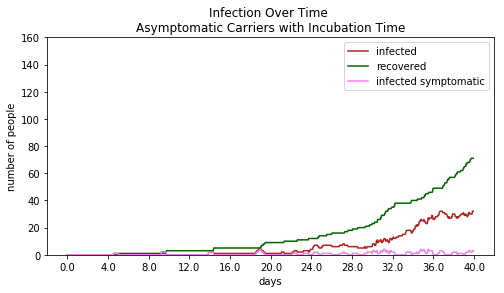

In [202]:
_ = plt.figure(figsize=(8, 4))
_ = plt.plot(asympt_df['time'], asympt_df['infected'], 
             color='firebrick', label='infected')
_ = plt.plot(asympt_df['time'], asympt_df['recovered'], 
             color='darkgreen', label='recovered')
_ = plt.plot(asympt_df['time'], asympt_df['infected symptomatic'], 
             color='violet', label='infected symptomatic')
_ = plt.ylabel('number of people')
_ = plt.xlabel('days')
_ = plt.title('Infection Over Time \n'+
              'Asymptomatic Carriers with Incubation Time')
_ = plt.legend()
_ = plt.xticks(np.linspace(0, len(asympt_df[['time']]), 11), np.linspace(0, 40, 11))
_ = plt.ylim([0, 160])
plt.show()

Mean: 0.00625
Standard deviation: 0.07880950133074056


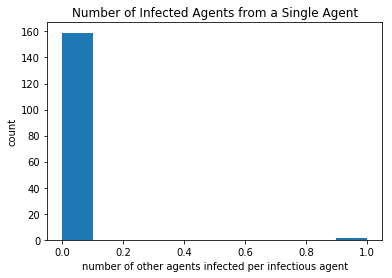

In [203]:
num_mean = agents["num infected"].mean()
print(f'Mean: {num_mean}')
num_std = agents["num infected"].std()
print(f'Standard deviation: {num_std}')
_ = plt.hist(agents['num infected'])
_ = plt.xlabel('number of other agents infected per infectious agent')
_ = plt.ylabel('count')
_ = plt.title('Number of Infected Agents from a Single Agent')
plt.show()

In [204]:
print(agents[agents['symptomatic'] == 1]['num infected'].mean())
print(agents[agents['symptomatic'] == 0]['num infected'].mean())

0.5
0.0


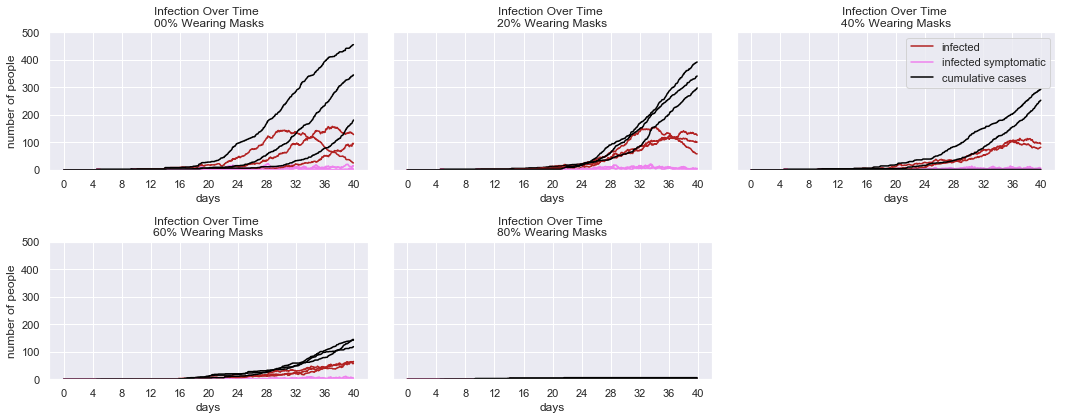

In [260]:
import seaborn as sns
import matplotlib.ticker as ticker
sns.set()
fig, ax = plt.subplots(2, 3, figsize=(15, 6), sharey=True)
for g in range(3):
    for h in range(5):
        # Name the datafile
        run_name = 'mask_per_0' + str(h * 2) + '_iter_' + str(g)
        dataname = '../../data/first_run/' + run_name + '.csv'
        temp_df = pd.read_csv(dataname, header=1)
        if h > 2:
            _ = ax[1,h-3].plot(temp_df['time'], temp_df['infected'], 
                     color='firebrick', label='infected')
            _ = ax[1,h-3].plot(temp_df['time'], temp_df['infected symptomatic'], 
                     color='violet', label='infected symptomatic')
            _ = ax[1,h-3].plot(temp_df['time'], temp_df['infected symptomatic'] +
                               temp_df['recovered'], color='black', 
                               label='cumulative cases')
        
            _ = ax[1,h-3].set_xlabel('days')
            _ = ax[1,h-3].set_title(f'Infection Over Time \n'+
                        f'{h*2}0% Wearing Masks')
            _ = ax[1, h-3].set_xticks(np.linspace(0, len(asympt_df[['time']]), 11))
            _ = ax[1, h-3].set_xticklabels([int(x) for x in np.linspace(0, 40, 11)])
            _ = ax[1, h-3].set_ylim([0, 500])
        else:
            _ = ax[0, h].plot(temp_df['time'], temp_df['infected'], 
                         color='firebrick', label='infected')
            _ = ax[0, h].plot(temp_df['time'], temp_df['infected symptomatic'], 
                         color='violet', label='infected symptomatic')
            _ = ax[0, h].plot(temp_df['time'], temp_df['infected symptomatic'] +
                               temp_df['recovered'], color='black', 
                               label='cumulative cases')
            _ = ax[0, h].set_xlabel('days')
            _ = ax[0, h].set_title(f'Infection Over Time \n'+
                            f'{h*2}0% Wearing Masks')
            _ = ax[0, h].set_xticks(np.linspace(0, len(asympt_df[['time']]), 11))
            _ = ax[0, h].set_xticklabels([int(x) for x in np.linspace(0, 40, 11)])
            _ = ax[0, h].set_ylim([0, 500])
        if g == 0:
            if h == 4:
                _ = ax[0, 2].legend()
            if h == 0:
                _ = ax[0, h].set_ylabel('number of people')
            if h == 3:
                _ = ax[1, h-3].set_ylabel('number of people')
fig.delaxes(ax[1, 2])
fig.tight_layout()
plt.savefig('../../mask_triplicate.png', dpi=100)
plt.show()

In [250]:
np.linspace(0, 40, 11)

array([ 0.,  4.,  8., 12., 16., 20., 24., 28., 32., 36., 40.])

In [251]:
np.linspace(0, len(asympt_df[['time']]), 11)

array([  0. ,  96.1, 192.2, 288.3, 384.4, 480.5, 576.6, 672.7, 768.8,
       864.9, 961. ])

Traceback (most recent call last):
  File "/Users/adam/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 215, in process
    func(*args, **kwargs)
  File "/Users/adam/anaconda3/lib/python3.7/site-packages/matplotlib/animation.py", line 999, in _start
    self._init_draw()
  File "/Users/adam/anaconda3/lib/python3.7/site-packages/matplotlib/animation.py", line 1740, in _init_draw
    self._draw_frame(next(self.new_frame_seq()))
  File "/Users/adam/anaconda3/lib/python3.7/site-packages/matplotlib/animation.py", line 1762, in _draw_frame
    self._drawn_artists = self._func(framedata, *self._args)
  File "<ipython-input-266-a46e42662d29>", line 389, in update
    f.write(temp_write)
ValueError: I/O operation on closed file.


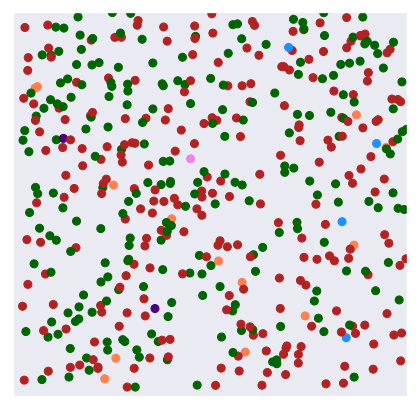

In [266]:
rand_num = 42
# Fixing random state for reproducibility
np.random.seed(rand_num)
g = 0
h = 1
# Name the datafile
run_name = 'mask_per_0' + str(h * 2) + '_iter_' + str(g)
dataname = '../../data/second_run/' + run_name + '.csv'
f = open(dataname, 'w')
# Write header of the file
f.write('# Data from simulation of 200 agents with various levels\
 of sheltering or mask usage\n')
f.write('time,percent sheltering,percent wearing masks,infected,\
exposed,recovered,infected with mask,susceptible with mask,\
infected symptomatic,infected asymptomatic\n')


"""Values of the simulation"""

# Figure ratio
fig_rat = .35355
# Set boundaries
xboundaries = [0, 60 * fig_rat]
yboundaries = [0, 60 * fig_rat]
xmax, ymax = xboundaries[1]+.5 , yboundaries[1]+.5

# Number of steps
N_steps = 960
# Number of agents
n_agents = int(4000 * round(fig_rat ** 2, 2))
# Set delta t
dt = 1
# Set velocity
velo = .15
# Set percent of sheltering in place
per_shelt = 0
# Set percent of masked agents
per_mask = int(h * 2)

# Define the array of agents with given properties
agents = np.zeros(n_agents, dtype=[('position', float, 2),
                                   ('velocity', float, 2),
                                   ('color', str, 20),
                                   ('state', str, 20),
                                   ('time', int, 1),
                                   ('symptomatic', int, 1),
                                   ('num infected', int, 1),
                                   ('mask', bool, 1),
                                   ('touch', int, 1)])



"""Calculate initial values of agents"""
# Define the initial random positions within the figure
agents['position'] = np.random.uniform(0, xmax, (n_agents, 2))
# Define the initial velocity angles
init_angles = np.random.uniform(0, 2 * np.pi, n_agents)
# Get initial x and y velocities from angles
velocities = np.array([[np.sin(x), np.cos(x)] for x in init_angles]) 
velocities *= velo
# Get percentage of agents 'sheltering'
num_shelt = int(per_shelt * n_agents)
# Make sheltering agents static (if any)
velocities[:num_shelt] = np.zeros((num_shelt, 2))
# Number of hours for asymptomatic incubation
asympt_incubate = 24 * 5.1
# Number of hours for symptomatic incubation
sympt_incubate = 24 * 4.6
# Number of hours for asymptomatic infection
asympt_infect = 7*24
# Number of hours for symptomatic infection
sympt_infect = 12
# Define values for infection gamma pdf
g_shape, g_scale = 0.25, 4
# Probability reduction for asymptomatic carrier
asym_prob = .66


"""Assign values to agents"""
# Assign velocities
agents['velocity'] = velocities
# Assign color (Navy is the default susceptible agent)
agents['color'] = np.array(['Navy'] * n_agents)
# Set agents to be symptomatic
agents['state'] = np.array(['Susceptible'] * n_agents)
agents['time'] = np.array([0] * n_agents)
n_mask = [True] * per_mask + [False] * (10-per_mask)
agents['mask'] = np.random.choice(n_mask, n_agents, replace=True)
agents['color'][agents['mask'] == True] = 'Dodgerblue'
agents['symptomatic'] = np.zeros(n_agents)
agents['num infected'] = np.zeros(n_agents)

# Make the one agent infected
agents['color'][0] = 'Violet'
agents['state'][0] = 'Exposed'
agents['time'][0] = 1
agents['mask'][0] = False
agents['symptomatic'][0] = 1


"""Define the values of the display"""
# Define the figure
fig = plt.figure(figsize=(20 * fig_rat, 20 * fig_rat))
ax = plt.axes(xlim=(-.5, xmax), ylim=(-.5, ymax))
plt.xticks([])
plt.yticks([])

# Initialize the plot
scatter = ax.scatter(agents['position'][:, 0], 
                     agents['position'][:, 1],
                     color=agents['color'],
                     s=64)

def update(i):
    """
    Take the information from the data stored in the agents array
    to calculate if an infected agent recovers, if two agents 
    interact, and if the agent bounces off a boundary
    """
    #print(i)
    #if i % int(N_steps / 10) == 0:
    #    print(str(i / int(N_steps / 10) * 10) + '% done')

    # Iterate over all agents 
    for j in range(n_agents):
        if agents['time'][j] != 0:
            # Calculate if agent is exposed or infected
            agent_j_infected = agents['state'][j] == 'Infected'
            agent_j_exposed = agents['state'][j] == 'Exposed'
            # Store time agent has been in this state
            agent_j_time = agents['time'][j]
            # Calculate if the agent is symptomatic or not
            agent_j_sympt = agents['symptomatic'][j]
            if agent_j_infected and agent_j_sympt:
                if agents['time'][j] >= sympt_infect:
                    if agents['color'][j] == 'Firebrick':
                        agents['state'][j] = 'Recovered'
                        agents['color'][j] = 'Firebrick'
                        agents['time'][j] = 1
                else:
                    agents['time'][j] += 1
            elif agent_j_infected and not agent_j_sympt:
                if agents['time'][j] >= asympt_infect:
                    agents['state'][j] = 'Recovered'
                    agents['color'][j] = 'Darkgreen'
                    agents['time'][j] = 1
                else:
                    agents['time'][j] += 1
            elif agent_j_exposed and agent_j_sympt:
                if agents['time'][j] >= sympt_incubate:
                    agents['state'][j] = 'Infected'
                    agents['color'][j] = 'Firebrick'
                    agents['time'][j] = 1
                else:
                    agents['time'][j] += 1
            elif agent_j_exposed and not agent_j_sympt:
                if agents['time'][j] >= asympt_incubate:
                    agents['state'][j] = 'Infected'
                    agents['color'][j] = 'Coral'
                    agents['time'][j] = 1
                else:
                    agents['time'][j] += 1
            elif agents['state'][j] == 'Recovered' and agents['symptomatic'][j] == 1:
                if agents['time'][j] > 14*24:
                    agents['time'][j] = 0
                    agents['state'][j] = 'Recovered'

                else:
                    agents['time'][j] +=1

        # New displacements (prior velocity times change in time)
        deltax_temp = dt * agents['velocity'][j, 0]
        deltay_temp = dt * agents['velocity'][j, 1]
        # New positions
        x = agents['position'][j, 0] + deltax_temp
        y = agents['position'][j, 1] + deltay_temp
        # Compute new velocity
        vx_temp = deltax_temp / dt
        vy_temp = deltay_temp / dt

        # Add interaction
        for k in range(n_agents):
            # Go through all other agents that could be interacted with
            if k != j:
                # Compute components of distance
                dx = agents['position'][j, 0] - agents['position'][k, 0]
                dy = agents['position'][j, 1] - agents['position'][k, 1]
                # Compute distance between agents
                dist_temp = np.sqrt(dx ** 2 + dy ** 2)
                # If distance of interaction is closer than both radii, collide
                if dist_temp <= 1:
                    agents['touch'][j] += 1
                    # Calculate if agents are infected
                    agent_j_infected = agents['state'][j] == 'Infected'
                    agent_k_infected = agents['state'][k] == 'Infected'
                    # Calculate if agents have recovered
                    agent_k_recover = agents['state'][k] == 'Recovered'
                    # Calculate if agents are susceptible
                    agent_j_suscept = agents['state'][j] == 'Susceptible'
                    agent_k_suscept = agents['state'][k] == 'Susceptible'
                    # Calculate if agents are symptomatic
                    agent_j_sympt = agents['symptomatic'][j] == 1
                    # If agent j is infected and agent k is susceptible
                    if agent_j_infected:
                        if agent_j_sympt and agent_k_suscept:
                            # Calculate probability of infection
                            temp_gam = np.random.gamma(g_shape, g_scale)
                            if temp_gam >= 1:
                                # Are the agents wearing masks
                                agent_j_mask = agents['mask'][j] == True
                                agent_k_mask = agents['mask'][k] == True
                                # If the infected is not wearing a mask
                                if not agent_j_mask and agent_k_mask:
                                    if np.random.random() >= .85:
                                        agents['state'][k] = 'Exposed'
                                        if np.random.random() >= .5:
                                            agents['symptomatic'][k] = 1
                                            agents['color'][k] = 'Violet'
                                            agents['num infected'][j] += 1
                                        else:
                                            agents['symptomatic'][k] = 0
                                            agents['color'][k] = 'Indigo'
                                        agents['time'][k] = 1

                                # If the susceptible is wearing a mask
                                elif agent_j_mask and not agent_k_mask:
                                    if np.random.random() >= .95:
                                        agents['state'][k] = 'Exposed'
                                        if np.random.random() >= .5:
                                            agents['symptomatic'][k] = 1
                                            agents['color'][k] = 'Violet'
                                            agents['num infected'][j] += 1
                                        else:
                                            agents['symptomatic'][k] = 0
                                            agents['color'][k] = 'Indigo'
                                        agents['time'][k] = 1

                                # If neither are wearing masks
                                elif not agent_j_mask and not agent_k_mask:
                                    agents['state'][k] = 'Exposed'
                                    if np.random.random() >= .5:
                                        agents['symptomatic'][k] = 1
                                        agents['color'][k] = 'Violet'
                                        agents['num infected'][j] += 1
                                    else:
                                        agents['symptomatic'][k] = 0
                                        agents['color'][k] = 'Indigo'
                                    agents['time'][k] = 1         
                        elif not agent_j_sympt and agent_k_suscept:
                            # Get the time that agent j has been infectious
                            agent_j_time = agents['time'][j]
                            # Normalize time to infectious period
                            agent_j_norm_time = agent_j_time / asympt_infect
                            # Define the probability of asymptomatic infect
                            temp_gam = np.random.gamma(g_shape, g_scale)
                            asympt_gam = temp_gam * asym_prob * agent_j_norm_time
                            if asympt_gam >=1:
                                # Are the agents wearing masks
                                agent_j_mask = agents['mask'][j] == True
                                agent_k_mask = agents['mask'][k] == True

                                # If the infected is not wearing a mask
                                if not agent_j_mask and agent_k_mask:
                                    if np.random.random() >= .85:
                                        agents['state'][k] = 'Exposed'
                                        if np.random.random() >= .5:
                                            agents['symptomatic'][k] = 1
                                            agents['color'][k] = 'Violet'
                                            agents['num infected'][j] += 1
                                        else:
                                            agents['symptomatic'][k] = 0
                                            agents['color'][k] = 'Indigo'
                                        agents['time'][k] = 1

                                # If the susceptible is wearing a mask
                                elif agent_j_mask and not agent_k_mask:
                                    if np.random.random() >= .95:
                                        agents['state'][k] = 'Exposed'
                                        if np.random.random() >= .5:
                                            agents['symptomatic'][k] = 1
                                            agents['color'][k] = 'Violet'
                                            agents['num infected'][j] += 1
                                        else:
                                            agents['symptomatic'][k] = 0
                                            agents['color'][k] = 'Indigo'
                                        agents['time'][k] = 1

                                # If neither are wearing masks
                                elif not agent_j_mask and not agent_k_mask:
                                    agents['state'][k] = 'Exposed'
                                    if np.random.random() >= .5:
                                        agents['symptomatic'][k] = 1
                                        agents['color'][k] = 'Violet'
                                        agents['num infected'][j] += 1
                                    else:
                                        agents['symptomatic'][k] = 0
                                        agents['color'][k] = 'Indigo'
                                    agents['time'][k] = 1
                        # Calculate if infection would have occured
                        elif agent_j_sympt:
                            if agent_k_infected or agent_k_recover:
                                # Get the time that agent j has been infectious
                                agent_j_time = agents['time'][j]
                                # Normalize time to infectious period
                                agent_j_norm_time = agent_j_time / asympt_infect
                                # Define the probability of asymptomatic infect
                                temp_gam = np.random.gamma(g_shape, g_scale)
                                asympt_gam = temp_gam * asym_prob * agent_j_norm_time
                                if temp_gam >= 1:
                                    # Are the agents wearing masks
                                    agent_j_mask = agents['mask'][j] == True
                                    agent_k_mask = agents['mask'][k] == True
                                    # If the infected is not wearing a mask
                                    if not agent_j_mask and agent_k_mask:
                                        if np.random.random() >= .85/2:
                                            agents['num infected'][j] += 1
                                    # If the susceptible is wearing a mask
                                    elif agent_j_mask and not agent_k_mask:
                                        if np.random.random() >= .95/2:
                                            agents['num infected'][j] += 1
                                    # If neither are wearing masks
                                    elif not agent_j_mask and not agent_k_mask:
                                        if np.random.random() >= .5:
                                            agents['num infected'][j] += 1
                        elif not agent_j_sympt:
                            if agent_k_infected or agent_k_recover:
                                # Get the time that agent j has been infectious
                                agent_j_time = agents['time'][j]
                                # Normalize time to infectious period
                                agent_j_norm_time = agent_j_time / asympt_infect
                                # Define the probability of asymptomatic infect
                                temp_gam = np.random.gamma(g_shape, g_scale)
                                asympt_gam = temp_gam * asym_prob * agent_j_norm_time
                                if asympt_gam >=1:
                                    # Are the agents wearing masks
                                    agent_j_mask = agents['mask'][j] == True
                                    agent_k_mask = agents['mask'][k] == True
                                    # If the infected is not wearing a mask
                                    if not agent_j_mask and agent_k_mask:
                                        if np.random.random() >= .85/2:
                                            agents['num infected'][j] += 1
                                    # If the susceptible is wearing a mask
                                    elif agent_j_mask and not agent_k_mask:
                                        if np.random.random() >= .95/2:
                                            agents['num infected'][j] += 1
                                    # If neither are wearing masks
                                    elif not agent_j_mask and not agent_k_mask:
                                        if np.random.random() >= .5:
                                            agents['num infected'][j] += 1


        # Bounce agents off wall if projected position is beyond boundary conditions
        if x >= xmax:
            x = 2 * xmax - deltax_temp - agents['position'][j, 0]
            vx_temp *= -1
        elif x <= 0:
            x = - deltax_temp - agents['position'][j, 0]
            vx_temp *= -1
        elif y >= ymax:
            y = 2 * ymax - deltay_temp - agents['position'][j, 1]
            vy_temp *= -1
        elif y <= 0:
            y = - deltay_temp - agents['position'][j, 1]
            vy_temp *= -1

        # 
        agents['position'][j] = np.array([x, y])
        agents['velocity'][j, 0] = vx_temp
        agents['velocity'][j, 1] = vy_temp

        # Update the scatter collection, with the new colors, sizes and positions.
        scatter.set_color(agents['color'])
        scatter.set_offsets(agents['position'])

    # Get values of the current time step
    temp_infected = sum(agents['state']=='Infected')
    temp_recovered = sum(agents['state']=='Recovered')
    temp_infect_mask = sum(agents[agents['mask']==True]['state'] == 'Infected')
    temp_suscept_mask = sum(agents[agents['mask']==True]['state'] == 'Susceptible')
    temp_exposed = sum(agents['state']=='Exposed')
    temp_infect_sympt = sum(agents[agents['symptomatic']==1]['state'] == 'Infected')
    temp_infect_asympt = sum(agents[agents['symptomatic']==0]['state'] == 'Infected')
    temp_write = str(i) + ',' + str(round(per_shelt * .1, 1)) + ',' + \
                 str(round(per_mask * .1, 1)) + ',' + str(temp_infected)+ ',' \
                 + str(temp_exposed) + ',' + str(temp_recovered) + ',' + \
                 str(temp_infect_mask) + ',' + str(temp_suscept_mask) + ',' + \
                 str(temp_infect_sympt) + ',' + str(temp_infect_asympt) + '\n'
    # Save current data to a file
    f.write(temp_write)

# Animate the simulation by iterating
animation = FuncAnimation(fig, update, frames=N_steps, interval=24)
temp_name = '../../data/first_run/' + run_name + '.gif'
animation.save(temp_name, writer='imagemagick')
f.close()

Mean: 10.402083333333334
Standard deviation: 9.653949744002308


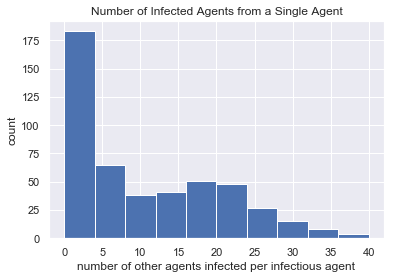

In [267]:
num_mean = agents["num infected"].mean()
print(f'Mean: {num_mean}')
num_std = agents["num infected"].std()
print(f'Standard deviation: {num_std}')
_ = plt.hist(agents['num infected'])
_ = plt.xlabel('number of other agents infected per infectious agent')
_ = plt.ylabel('count')
_ = plt.title('Number of Infected Agents from a Single Agent')
plt.show()

In [268]:
print(agents[agents['symptomatic'] == 1]['num infected'].mean())
print(agents[agents['symptomatic'] == 0]['num infected'].mean())

2.561181434599156
18.049382716049383


In [269]:
# Start with EDA of yesterday's simulated data
# Read in file
asympt_df = pd.read_csv(dataname, header=1)
asympt_df.head()

,time,percent sheltering,percent wearing masks,infected,exposed,recovered,infected with mask,susceptible with mask,infected symptomatic,infected asymptomatic
0,0,0.0,0.2,0,1,0,0,101,0,0
1,0,0.0,0.2,0,1,0,0,101,0,0
2,1,0.0,0.2,0,1,0,0,101,0,0
3,2,0.0,0.2,0,1,0,0,101,0,0
4,3,0.0,0.2,0,1,0,0,101,0,0


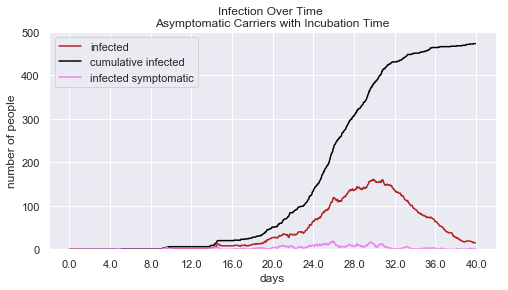

In [273]:
_ = plt.figure(figsize=(8, 4))
_ = plt.plot(asympt_df['time'], asympt_df['infected'], 
             color='firebrick', label='infected')
_ = plt.plot(asympt_df['time'], asympt_df['recovered']+
             asympt_df['infected'], color='black', label='cumulative infected')
_ = plt.plot(asympt_df['time'], asympt_df['infected symptomatic'], 
             color='violet', label='infected symptomatic')
_ = plt.ylabel('number of people')
_ = plt.xlabel('days')
_ = plt.title('Infection Over Time \n'+
              'Asymptomatic Carriers with Incubation Time')
_ = plt.legend()
_ = plt.xticks(np.linspace(0, len(asympt_df[['time']]), 11), np.linspace(0, 40, 11))
_ = plt.ylim([0, 500])
plt.show()